In [133]:
!python simu1_generate_data.py

delta:  0
generating eval set:  0
delta:  0
generating eval set:  1
delta:  0
generating eval set:  2
delta:  0
generating eval set:  3
delta:  0
generating eval set:  4
delta:  0
generating eval set:  5
delta:  0
generating eval set:  6
delta:  0
generating eval set:  7
delta:  0
generating eval set:  8
delta:  0
generating eval set:  9
delta:  0
generating eval set:  10
delta:  0
generating eval set:  11
delta:  0
generating eval set:  12
delta:  0
generating eval set:  13
delta:  0
generating eval set:  14
delta:  0
generating eval set:  15
delta:  0
generating eval set:  16
delta:  0
generating eval set:  17
delta:  0
generating eval set:  18
delta:  0
generating eval set:  19
delta:  0.5
generating eval set:  0
delta:  0.5
generating eval set:  1
delta:  0.5
generating eval set:  2
delta:  0.5
generating eval set:  3
delta:  0.5
generating eval set:  4
delta:  0.5
generating eval set:  5
delta:  0.5
generating eval set:  6
delta:  0.5
generating eval set:  7
delta:  0.5
generating

In [1]:
!python calculate_rej_rate.py

In [4]:
rej_rate = pd.read_csv(args.save_dir + '/rej_rate_at_inf_ratio_0.3_rho_0.4.txt', header=None, sep=' ')
rej_rate

,0,1,2,3,4
0,0.000,0.100,0.200,0.300,0.400
1,0.056,0.056,0.059,0.059,0.094


In [57]:
import torch
import math
import numpy as np
import os
import pandas as pd

from models.dynamic_net import Vcnet, TR #Drnet
from data.data import get_iter, split
from utils.eval import *

#import argparse

import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
def split(dat, t_grid, inf_ratio = 0.3):
    n_sample = len(t_grid[0])
    n_train = round(n_sample * (1-inf_ratio))

    perm = np.random.permutation(n_sample)
    dat = dat[perm, :]
    t_grid = t_grid[:, perm]
    training = dat[:n_train, :]
    testing = dat[(n_train+1):, :]
    t_grid_test = t_grid[:, (n_train+1):]
    return torch.from_numpy(training).float(), torch.from_numpy(testing).float(), torch.from_numpy(t_grid_test).float()

In [32]:
from data.simu2 import *

In [376]:
inf_ratio = 0.15
delta = 0.5

In [3]:
class args_:
    data_dir = 'dataset/simu2/eval/0'
    save_dir = 'logs/simu2/eval'
    n_epochs = 1000
    verbose = 100
    plt_adrf = True
    
args = args_

In [378]:
data = pd.read_csv(load_path + f'/delta_{delta}_data.txt', header=None, sep=' ')
data = data.to_numpy()
t_grid_dat = pd.read_csv(load_path + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
t_grid_dat = t_grid_dat.to_numpy()
train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

In [379]:
n_test = test_matrix.shape[0]
counterfactual = torch.zeros(n_test, n_test)
for i in range(n_test):
    for j in range(n_test):
        counterfactual[i, j] = t_x_y(t = test_matrix[j, 0], x = test_matrix[i, 1:5], delta = delta)

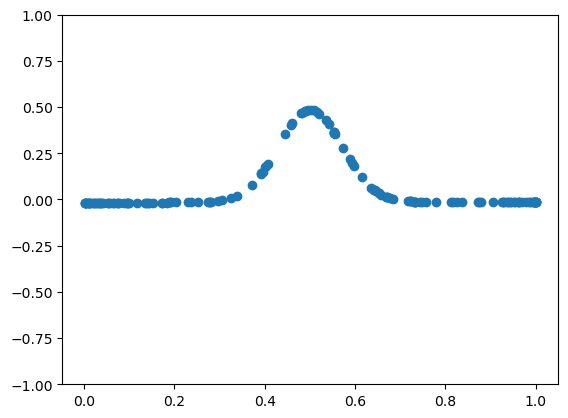

In [380]:
plt.scatter(t_grid[0], torch.mean(counterfactual, 0))
plt.ylim(-1, 1)
plt.show()

In [37]:
def adjust_learning_rate(optimizer, init_lr, epoch):
    if lr_type == 'cos':  # cos without warm-up
        lr = 0.5 * init_lr * (1 + math.cos(math.pi * epoch / num_epoch))
    elif lr_type == 'exp':
        step = 1
        decay = 0.96
        lr = init_lr * (decay ** (epoch // step))
    elif lr_type == 'fixed':
        lr = init_lr
    else:
        raise NotImplementedError
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def save_checkpoint(state, checkpoint_dir='.'):
    filename = os.path.join(checkpoint_dir, model_name + '_ckpt.pth.tar')
    print('=> Saving checkpoint to {}'.format(filename))
    torch.save(state, filename)

# criterion
def criterion(out, y, alpha=0.5, epsilon=1e-6):
    return ((out[1].squeeze() - y.squeeze())**2).mean() - alpha * torch.log(out[0] + epsilon).mean()

def criterion_TR(out, trg, y, beta=1., epsilon=1e-6):
    # out[1] is Q
    # out[0] is g
    return beta * ((y.squeeze() - trg.squeeze()/(out[0].squeeze() + epsilon) - out[1].squeeze())**2).mean()

In [555]:
def calculate_delta(model, test_matrix, t_grid_hat, targetreg):
    n_test = test_matrix.shape[0]
    mu_tr = torch.zeros(n_test, n_test)

    test_loader = get_iter(test_matrix, batch_size=n_test, shuffle=False)
    for _ in range(n_test):
        for idx, (inputs, y) in enumerate(test_loader):
            t = inputs[:, 0]
            t *= 0
            t += t_grid_hat[0, _]
            x = inputs[:, 1:]
            break
        out = model.forward(t, x)
        g = out[0].data.squeeze()
        out = out[1].data.squeeze()
        
        tr_out = targetreg(t).data
        mu_tr[_,:] = out + tr_out / (g + 1e-6)

    g_hat = t_grid_hat[1]
    g_tilde = torch.mean(g_hat).repeat(n_test)
    delta = torch.mean((mu_tr - torch.reshape(g_hat, (n_test,1)).repeat(1, n_test)) ** 2, 1) - torch.mean((mu_tr - torch.reshape(g_tilde, (n_test,1)).repeat(1, n_test)) ** 2, 1)
    return delta.numpy()

In [541]:
tmp = calculate_delta(model, test_matrix, t_grid_hat, TargetReg)

In [569]:
n_sample = data.shape[0]
n_train = round(n_sample * (1-inf_ratio)) + 1
n_test = n_sample - n_train
n_test

149

In [570]:
def calculate_U_delta(args, delta, alpha = 0.05, U = 5, inf_ratio = 0.15):
    load_path = args.data_dir
    save_path = args.save_dir
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    data = pd.read_csv(load_path + f'/delta_{delta}_data.txt', header=None, sep=' ')
    data = data.to_numpy()
    t_grid_dat = pd.read_csv(load_path + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
    t_grid_dat = t_grid_dat.to_numpy()

    # optimizer
    lr_type = 'fixed'
    wd = 5e-3
    momentum = 0.9
    # targeted regularization optimizer
    tr_wd = 5e-3

    num_epoch = args.n_epochs

    # check val loss
    verbose = args.verbose

    #grid = []
    #MSE = []

    # choose from {'Tarnet', 'Tarnet_tr', 'Drnet', 'Drnet_tr', 'Vcnet', 'Vcnet_tr'}
    method_list = ['Vcnet_tr']
    
    # delta
    n_sample = data.shape[0]
    n_train = round(n_sample * (1-inf_ratio)) + 1
    n_test = n_sample - n_train
    delta = np.zeros(n_test * U).reshape(U, n_test)
    for _ in range(U):
        perm = np.random.permutation(data.shape[0])
        data[:,0] = data[perm, 0]
        t_grid_dat[0, :] = t_grid_dat[0, perm]
        train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

        train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
        test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

        for model_name in method_list:
            # import model
            if model_name == 'Vcnet' or model_name == 'Vcnet_tr':
                cfg_density = [(4, 50, 1, 'relu'), (50, 50, 1, 'relu')]
                num_grid = 10
                cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
                degree = 2
                knots = [0.33, 0.66]
                model = Vcnet(cfg_density, num_grid, cfg, degree, knots)
                model._initialize_weights()

            elif model_name == 'Drnet' or model_name == 'Drnet_tr':
                cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
                num_grid = 10
                cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
                isenhance = 1
                model = Drnet(cfg_density, num_grid, cfg, isenhance=isenhance)
                model._initialize_weights()

            elif model_name == 'Tarnet' or model_name == 'Tarnet_tr':
                cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
                num_grid = 10
                cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
                isenhance = 0
                model = Drnet(cfg_density, num_grid, cfg, isenhance=isenhance)
                model._initialize_weights()

            # use Target Regularization?
            if model_name == 'Vcnet_tr' or model_name == 'Drnet_tr' or model_name == 'Tarnet_tr':
                isTargetReg = 1
            else:
                isTargetReg = 0

            if isTargetReg:
                tr_knots = list(np.arange(0.1, 1, 0.1))
                tr_degree = 2
                TargetReg = TR(tr_degree, tr_knots)
                TargetReg._initialize_weights()

            # best cfg for each model
            if model_name == 'Tarnet':
                init_lr = 0.05
                alpha = 1.0
            elif model_name == 'Tarnet_tr':
                init_lr = 0.05
                alpha = 0.5
                tr_init_lr = 0.001
                beta = 1.
            elif model_name == 'Drnet':
                init_lr = 0.05
                alpha = 1.
            elif model_name == 'Drnet_tr':
                init_lr = 0.05
                # init_lr = 0.05 tuned
                alpha = 0.5
                tr_init_lr = 0.001
                beta = 1.
            elif model_name == 'Vcnet':
                init_lr = 0.0001
                alpha = 0.5
            elif model_name == 'Vcnet_tr':
                init_lr = 0.0001
                alpha = 0.5
                tr_init_lr = 0.001
                beta = 1.

            optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=wd, nesterov=True)

            if isTargetReg:
                tr_optimizer = torch.optim.SGD(TargetReg.parameters(), lr=tr_init_lr, weight_decay=tr_wd)

            print('model = ', model_name)
            loss_values = []
            for epoch in range(num_epoch):
                for idx, (inputs, y) in enumerate(train_loader):
                    t = inputs[:, 0]
                    x = inputs[:, 1:]

                    if isTargetReg:
                        optimizer.zero_grad()
                        out = model.forward(t, x)
                        trg = TargetReg(t)
                        loss = criterion(out, y, alpha=alpha) + criterion_TR(out, trg, y, beta=beta)
                        loss.backward()
                        optimizer.step()

                        tr_optimizer.zero_grad()
                        out = model.forward(t, x)
                        trg = TargetReg(t)
                        tr_loss = criterion_TR(out, trg, y, beta=beta)
                        tr_loss.backward()
                        tr_optimizer.step()
                    else:
                        optimizer.zero_grad()
                        out = model.forward(t, x)
                        loss = criterion(out, y, alpha=alpha)
                        loss.backward()
                        optimizer.step()

                    loss_values.append(loss.data)

                if epoch % verbose == 0:
                    print(f'iteration: {_ + 1}/{U}')
                    print('current epoch: ', epoch)
                    print('loss: ', loss.data)



            if isTargetReg:
                t_grid_hat, mse = curve(model, test_matrix, t_grid, targetreg=TargetReg)
            else:
                t_grid_hat, mse = curve(model, test_matrix, t_grid)

            mse = float(mse)
            #print('current loss: ', float(loss.data))
            #print('current test loss: ', mse)
            #print('-----------------------------------------------------------------')

            #save_checkpoint({
            #    'model': model_name,
            #    'best_test_loss': mse,
            #    'model_state_dict': model.state_dict(),
            #    'TR_state_dict': TargetReg.state_dict() if isTargetReg else None,
            #}, checkpoint_dir=save_path)

            #print('-----------------------------------------------------------------')

            #grid.append(t_grid_hat)
            #MSE.append(mse)

            #plt.plot(loss_values, label = 'train')
            #plt.legend(loc='upper right')
            #plt.show()
            
            delta[_, :] = calculate_delta(model, test_matrix, t_grid_hat, TargetReg)
    return delta

In [571]:
delta = calculate_U_delta(args, delta = 0.5, alpha = 0.05, U = 3, inf_ratio = 0.15)

model =  Vcnet_tr
iteration: 1/3
current epoch:  0
loss:  tensor(2.1503)
iteration: 1/3
current epoch:  100
loss:  tensor(1.7364)
iteration: 1/3
current epoch:  200
loss:  tensor(1.7172)
iteration: 1/3
current epoch:  300
loss:  tensor(1.7091)
iteration: 1/3
current epoch:  400
loss:  tensor(1.7044)
iteration: 1/3
current epoch:  500
loss:  tensor(1.7009)
iteration: 1/3
current epoch:  600
loss:  tensor(1.6979)
iteration: 1/3
current epoch:  700
loss:  tensor(1.6951)
iteration: 1/3
current epoch:  800
loss:  tensor(1.6926)
iteration: 1/3
current epoch:  900
loss:  tensor(1.6901)
model =  Vcnet_tr
iteration: 2/3
current epoch:  0
loss:  tensor(2.1725)
iteration: 2/3
current epoch:  100
loss:  tensor(1.7463)
iteration: 2/3
current epoch:  200
loss:  tensor(1.7282)
iteration: 2/3
current epoch:  300
loss:  tensor(1.7202)
iteration: 2/3
current epoch:  400
loss:  tensor(1.7143)
iteration: 2/3
current epoch:  500
loss:  tensor(1.7098)
iteration: 2/3
current epoch:  600
loss:  tensor(1.7059)

In [587]:
def turn_rho(delta0, rho, alpha = 0.05):
    U, n_test = delta0.shape
    p_val = np.zeros(len(rho) * U).reshape(len(rho), U)
    rej = np.zeros(len(rho))
    for _ in range(len(rho)):
        noise = rho[_]
        delta = delta0 + noise * np.random.normal(size = U * n_test).reshape(U, n_test)
        theta = delta.sum(axis = 1) / (np.sqrt(n_test) * delta.std(axis = 1))
        p_val[_,:] = norm.cdf(theta)
        rej[_] = (p_val[_,:] <= alpha).mean()
    return p_val, rej

In [588]:
p_val, rej = turn_rho(delta, rho = [0.01, 0.1, 1, 10, 100])

In [589]:
rej

array([0.        , 0.        , 0.33333333, 0.        , 0.        ])

In [580]:
theta = delta.sum(axis = 1)/(np.sqrt(n_test) * delta.std(axis = 1))
tmp = norm.cdf(theta)

In [584]:
(tmp <= 0.05).mean()

1.0

In [554]:
delta[2].shape

torch.Size([149])

In [529]:
rej

array([0.88, 0.83, 0.62, 0.59, 0.56, 0.56])

In [525]:
tmp = np.zeros(5)
for _ in range(30):
    tmp += (p_val[_,:] <= 0.05)
tmp/30

array([0.3       , 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [518]:
(p_val <= 0.05).mean(axis = 0)

array([0.3       , 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [526]:
rej

array([0.86666667, 0.53333333, 0.5       , 0.4       , 0.4       ])

In [490]:
rho

[0.01, 0.15, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1]

In [488]:
rej # (inf_ratio, rho) = (0.3, )

array([0.96666667, 0.7       , 0.76666667, 0.7       ])

In [491]:
rej # (inf_ratio, rho) = (0.15, 0.1)

array([0.83333333, 0.43333333, 0.5       , 0.43333333, 0.43333333,
       0.43333333, 0.43333333, 0.43333333, 0.43333333])

model =  Vcnet_tr
current epoch:  0
loss:  tensor(2.1017)
current epoch:  100
loss:  tensor(1.7153)
current epoch:  200
loss:  tensor(1.7056)
current epoch:  300
loss:  tensor(1.7006)
current epoch:  400
loss:  tensor(1.6969)
current epoch:  500
loss:  tensor(1.6940)
current epoch:  600
loss:  tensor(1.6915)
current epoch:  700
loss:  tensor(1.6893)
current epoch:  800
loss:  tensor(1.6875)
current epoch:  900
loss:  tensor(1.6856)
current loss:  1.683835744857788
current test loss:  0.04014138877391815
-----------------------------------------------------------------


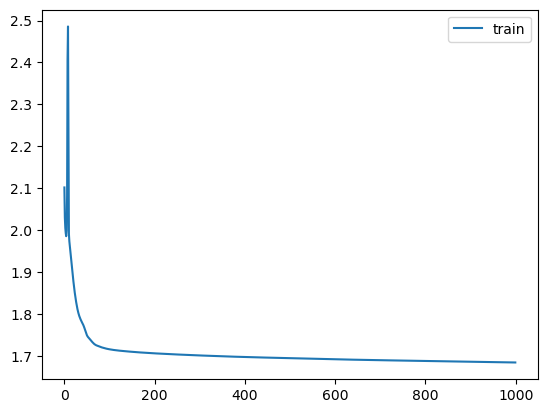

In [530]:
delta = 0.5

load_path = args.data_dir
save_path = args.save_dir
if not os.path.exists(save_path):
    os.makedirs(save_path)

data = pd.read_csv(load_path + f'/delta_{delta}_data.txt', header=None, sep=' ')
data = data.to_numpy()
t_grid_dat = pd.read_csv(load_path + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
t_grid_dat = t_grid_dat.to_numpy()

# optimizer
lr_type = 'fixed'
wd = 5e-3
momentum = 0.9
# targeted regularization optimizer
tr_wd = 5e-3

num_epoch = args.n_epochs

# check val loss
verbose = args.verbose

grid = []
MSE = []

# choose from {'Tarnet', 'Tarnet_tr', 'Drnet', 'Drnet_tr', 'Vcnet', 'Vcnet_tr'}
method_list = ['Vcnet_tr']

perm = np.random.permutation(data.shape[0])
data[:,0] = data[perm, 0]
t_grid_dat[0, :] = t_grid_dat[0, perm]
train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

for model_name in method_list:
    # import model
    if model_name == 'Vcnet' or model_name == 'Vcnet_tr':
        cfg_density = [(4, 50, 1, 'relu'), (50, 50, 1, 'relu')]
        num_grid = 10
        cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
        degree = 2
        knots = [0.33, 0.66]
        model = Vcnet(cfg_density, num_grid, cfg, degree, knots)
        model._initialize_weights()

    elif model_name == 'Drnet' or model_name == 'Drnet_tr':
        cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
        num_grid = 10
        cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
        isenhance = 1
        model = Drnet(cfg_density, num_grid, cfg, isenhance=isenhance)
        model._initialize_weights()

    elif model_name == 'Tarnet' or model_name == 'Tarnet_tr':
        cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
        num_grid = 10
        cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
        isenhance = 0
        model = Drnet(cfg_density, num_grid, cfg, isenhance=isenhance)
        model._initialize_weights()

    # use Target Regularization?
    if model_name == 'Vcnet_tr' or model_name == 'Drnet_tr' or model_name == 'Tarnet_tr':
        isTargetReg = 1
    else:
        isTargetReg = 0

    if isTargetReg:
        tr_knots = list(np.arange(0.1, 1, 0.1))
        tr_degree = 2
        TargetReg = TR(tr_degree, tr_knots)
        TargetReg._initialize_weights()

    # best cfg for each model
    if model_name == 'Tarnet':
        init_lr = 0.05
        alpha = 1.0
    elif model_name == 'Tarnet_tr':
        init_lr = 0.05
        alpha = 0.5
        tr_init_lr = 0.001
        beta = 1.
    elif model_name == 'Drnet':
        init_lr = 0.05
        alpha = 1.
    elif model_name == 'Drnet_tr':
        init_lr = 0.05
        # init_lr = 0.05 tuned
        alpha = 0.5
        tr_init_lr = 0.001
        beta = 1.
    elif model_name == 'Vcnet':
        init_lr = 0.0001
        alpha = 0.5
    elif model_name == 'Vcnet_tr':
        init_lr = 0.0001
        alpha = 0.5
        tr_init_lr = 0.001
        beta = 1.

    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=wd, nesterov=True)

    if isTargetReg:
        tr_optimizer = torch.optim.SGD(TargetReg.parameters(), lr=tr_init_lr, weight_decay=tr_wd)

    print('model = ', model_name)
    loss_values = []
    for epoch in range(num_epoch):
        for idx, (inputs, y) in enumerate(train_loader):
            t = inputs[:, 0]
            x = inputs[:, 1:]

            if isTargetReg:
                optimizer.zero_grad()
                out = model.forward(t, x)
                trg = TargetReg(t)
                loss = criterion(out, y, alpha=alpha) + criterion_TR(out, trg, y, beta=beta)
                loss.backward()
                optimizer.step()

                tr_optimizer.zero_grad()
                out = model.forward(t, x)
                trg = TargetReg(t)
                tr_loss = criterion_TR(out, trg, y, beta=beta)
                tr_loss.backward()
                tr_optimizer.step()
            else:
                optimizer.zero_grad()
                out = model.forward(t, x)
                loss = criterion(out, y, alpha=alpha)
                loss.backward()
                optimizer.step()

            loss_values.append(loss.data)

        if epoch % verbose == 0:
            print('current epoch: ', epoch)
            print('loss: ', loss.data)



    if isTargetReg:
        t_grid_hat, mse = curve(model, test_matrix, t_grid, targetreg=TargetReg)
    else:
        t_grid_hat, mse = curve(model, test_matrix, t_grid)

    mse = float(mse)
    print('current loss: ', float(loss.data))
    print('current test loss: ', mse)
    print('-----------------------------------------------------------------')

    #save_checkpoint({
    #    'model': model_name,
    #    'best_test_loss': mse,
    #    'model_state_dict': model.state_dict(),
    #    'TR_state_dict': TargetReg.state_dict() if isTargetReg else None,
    #}, checkpoint_dir=save_path)

    #print('-----------------------------------------------------------------')

    grid.append(t_grid_hat)
    MSE.append(mse)

    plt.plot(loss_values, label = 'train')
    plt.legend(loc='upper right')
    plt.show()

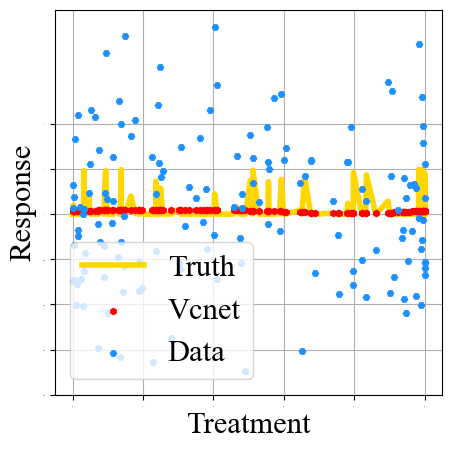

In [499]:
if args.plt_adrf:
    import matplotlib.pyplot as plt

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 22,
    }

    font_legend = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 22,
    }
    plt.figure(figsize=(5, 5))

    c1 = 'gold'
    c2 = 'red'
    c3 = 'dodgerblue'

    truth_grid = t_grid[:,t_grid[0,:].argsort()]
    x = truth_grid[0, :]
    y = truth_grid[1, :]
    plt.plot(x, y, marker='', ls='-', label='Truth', linewidth=4, color=c1)

    x = grid[0][0, :]
    y = grid[0][1, :]
    plt.scatter(x, y, marker='h', label='Vcnet', alpha=1, zorder=2, color=c2, s=20)

    x = test_matrix[:,0]
    y = test_matrix[:,-1]
    plt.scatter(x, y, marker='H', label='Data', alpha=1, zorder=3, color=c3, s=20)

    plt.yticks(np.arange(-2.0, 1.1, 0.5), fontsize=0, family='Times New Roman')
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=0, family='Times New Roman')
    plt.grid()
    plt.legend(prop=font_legend, loc='lower left')
    plt.xlabel('Treatment', font1)
    plt.ylabel('Response', font1)

    plt.savefig(save_path + "/Vc_Dr.pdf", bbox_inches='tight')

In [531]:
def test0(model, test_matrix, t_grid_hat, targetreg, rho = [0.01, 0.15, 0.05, 0.1, 1, 10]):
    n_test = test_matrix.shape[0]
    mu = torch.zeros(n_test, n_test)
    pi = torch.zeros(n_test, n_test)
    mu_tr = torch.zeros(n_test, n_test)

    test_loader = get_iter(test_matrix, batch_size=n_test, shuffle=False)
    for _ in range(n_test):
        for idx, (inputs, y) in enumerate(test_loader):
            t = inputs[:, 0]
            t *= 0
            t += t_grid_hat[0, _]
            x = inputs[:, 1:]
            break
        out = model.forward(t, x)
        g = out[0].data.squeeze()
        out = out[1].data.squeeze()
        mu[_,:] = out
        pi[_,:] = g
        
        tr_out = targetreg(t).data
        mu_tr[_,:] = out + tr_out / (g + 1e-6)

    #mu_mean = torch.mean(mu, 1, True)
    #pi_mean = torch.mean(pi, 1, True)
    #y_hat = (y.repeat(n_test, 1) - mu) / (pi + 1e-6) * pi_mean.repeat(1, n_test) + mu_mean.repeat(1, n_test)
    g_hat = t_grid_hat[1]
    g_tilde = torch.mean(g_hat).repeat(n_test)
    #delta = torch.mean((y_hat - torch.reshape(g_hat, (n_test,1)).repeat(1, n_test)) ** 2, 1) - torch.mean((y_hat - torch.reshape(g_tilde, (n_test,1)).repeat(1, n_test)) ** 2, 1)
    delta = torch.mean((mu_tr - torch.reshape(g_hat, (n_test,1)).repeat(1, n_test)) ** 2, 1) - torch.mean((mu_tr - torch.reshape(g_tilde, (n_test,1)).repeat(1, n_test)) ** 2, 1)

    rho = np.array(rho)
    delta0 = delta.repeat(len(rho), 1).numpy()
    noise = rho.reshape(-1,1) * np.random.normal(size = n_test)
    delta = delta0 + noise
    theta = delta.sum(axis = 1) / (np.sqrt(n_test) * delta.std(axis = 1))
    p_val = norm.cdf(theta)
    return [p_val, delta0, theta] #[p_val, y_hat, mu, mu_tr, pi, y]

In [532]:
[p_val, delta0, theta] = test0(model, test_matrix, t_grid_hat, TargetReg, rho = [0.01, 0.1, 1, 10, 100]) # rho = 0.01
p_val

array([0.09206258, 0.59775004, 0.65735574, 0.66312811, 0.66370321])

In [537]:
rho = [0.01, 0.1, 1, 10, 100]
rho = np.array(rho)
noise = rho.reshape(-1,1) * np.random.normal(size = n_test)
delta = delta0 + noise 
delta.sum(axis = 1) / (np.sqrt(n_test) * delta.std(axis = 1))

array([-2.03008369, -0.52852232, -0.37541187, -0.3600854 , -0.35855261])

In [538]:

delta0.sum(axis = 1) / (np.sqrt(n_test) * delta0.std(axis = 1))

array([-12.167435, -12.167435, -12.167435, -12.167435, -12.167435],
      dtype=float32)

In [391]:
pi

tensor([[0.1063, 0.1063, 0.1063,  ..., 0.1063, 0.1063, 0.1063],
        [0.1014, 0.1014, 0.1014,  ..., 0.1014, 0.1014, 0.1014],
        [0.1015, 0.1015, 0.1016,  ..., 0.1016, 0.1015, 0.1015],
        ...,
        [0.0835, 0.0835, 0.0835,  ..., 0.0835, 0.0835, 0.0835],
        [0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833],
        [0.1035, 0.1035, 0.1036,  ..., 0.1035, 0.1035, 0.1035]])

In [394]:
mu_mean = torch.mean(mu, 1, True)
pi_mean = torch.mean(pi, 1, True)
y_hat = (y.repeat(n_test, 1) - mu) / (pi + 1e-6) * pi_mean.repeat(1, n_test) + mu_mean.repeat(1, n_test)

In [421]:
mu_mean = torch.mean(mu, 1)
pi_mean = torch.mean(pi, 1)
y_hat1 = (y[0].repeat(1, n_test) - mu[:,0]) / (pi[:, 0] + 1e-6) * pi_mean + mu_mean

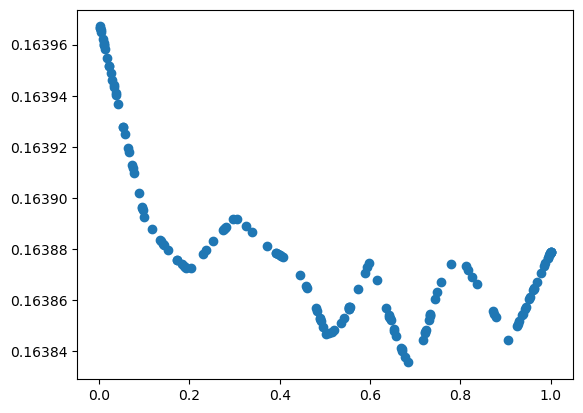

In [445]:
#plt.scatter(t_grid[0], pi[:,0])
plt.scatter(t_grid[0], torch.mean(y_hat, 1))
plt.show()

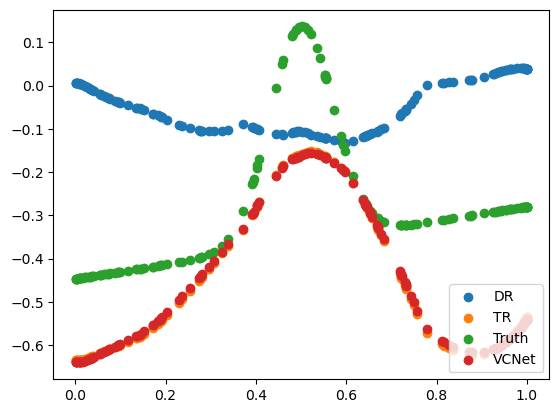

In [446]:
idx = 10
plt.scatter(t_grid[0], y_hat[:,idx], label = 'DR')
plt.scatter(t_grid[0], mu_tr[:, idx], label = 'TR')
#plt.scatter(t_grid[0], y_hat1, label = 'DR')
plt.scatter(t_grid[0], counterfactual[idx,:], label = 'Truth')
plt.scatter(t_grid[0], mu[:,idx], label = 'VCNet')
#plt.ylim(-1, 1)
plt.legend(loc = 'lower right')
plt.show()

In [386]:
g_hat = t_grid_hat[1]
g_tilde = torch.mean(g_hat).repeat(n_test)
delta = torch.mean((mu_tr - torch.reshape(g_hat, (n_test,1)).repeat(1, n_test)) ** 2, 1) - torch.mean((mu_tr - torch.reshape(g_tilde, (n_test,1)).repeat(1, n_test)) ** 2, 1)

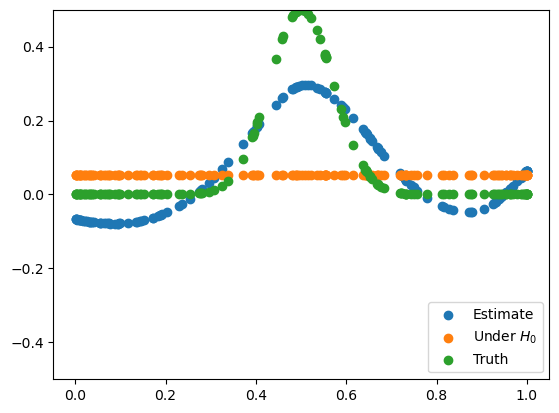

In [416]:
plt.scatter(t_grid[0], g_hat, label = 'Estimate')
plt.scatter(t_grid[0], g_tilde, label = 'Under $H_0$')
plt.scatter(t_grid[0], t_grid[1], label = 'Truth')
plt.ylim(-0.5, 0.5)
plt.legend(loc = 'lower right')
plt.show()

In [372]:
torch.mean((y_hat - counterfactual) ** 2)

tensor(0.4979)

In [373]:
torch.mean((torch.transpose(mu, 0, 1) - counterfactual) ** 2)

tensor(0.4120)

In [374]:
torch.mean((torch.transpose(mu_tr, 0, 1) - counterfactual) ** 2)

tensor(0.0110)

In [594]:
!python turnning.py

delta: 0.5
inf_ratio: 0.1
model =  Vcnet_tr
/Users/yanyuchen/Documents/GitHub/causal_net_test/models/dynamic_net.py:83: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1680607622815/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  x_feature_weight = torch.matmul(self.weight.T, x_feature.T).T # bs, outd, d
iteration: 1/1
current epoch:  0
loss:  tensor(2.1672)
iteration: 1/1
current epoch:  100
loss:  tensor(1.7475)
iteration: 1/1
current epoch:  200
loss:  tensor(1.7263)
iteration: 1/1
current epoch:  300
loss:  tensor(1.7187)
iteration: 1/1
current epoch:  400
loss:  tensor(1.7134)
iteration: 1/1
current epoch:  500
loss:  tensor(1.7089)
iteration: 1/1
current epoch:  600

In [167]:
!python simu2_generate_data.py

generating eval set:  0
generating eval set:  1
generating eval set:  2
generating eval set:  3
generating eval set:  4
generating eval set:  5
generating eval set:  6
generating eval set:  7
generating eval set:  8
generating eval set:  9
generating eval set:  10
generating eval set:  11
generating eval set:  12
generating eval set:  13
generating eval set:  14
generating eval set:  15
generating eval set:  16
generating eval set:  17
generating eval set:  18
generating eval set:  19
generating eval set:  20
generating eval set:  21
generating eval set:  22
generating eval set:  23
generating eval set:  24
generating eval set:  25
generating eval set:  26
generating eval set:  27
generating eval set:  28
generating eval set:  29
generating eval set:  30
generating eval set:  31
generating eval set:  32
generating eval set:  33
generating eval set:  34
generating eval set:  35
generating eval set:  36
generating eval set:  37
generating eval set:  38
generating eval set:  39
generating

generating eval set:  320
generating eval set:  321
generating eval set:  322
generating eval set:  323
generating eval set:  324
generating eval set:  325
generating eval set:  326
generating eval set:  327
generating eval set:  328
generating eval set:  329
generating eval set:  330
generating eval set:  331
generating eval set:  332
generating eval set:  333
generating eval set:  334
generating eval set:  335
generating eval set:  336
generating eval set:  337
generating eval set:  338
generating eval set:  339
generating eval set:  340
generating eval set:  341
generating eval set:  342
generating eval set:  343
generating eval set:  344
generating eval set:  345
generating eval set:  346
generating eval set:  347
generating eval set:  348
generating eval set:  349
generating eval set:  350
generating eval set:  351
generating eval set:  352
generating eval set:  353
generating eval set:  354
generating eval set:  355
generating eval set:  356
generating eval set:  357
generating e

generating eval set:  636
generating eval set:  637
generating eval set:  638
generating eval set:  639
generating eval set:  640
generating eval set:  641
generating eval set:  642
generating eval set:  643
generating eval set:  644
generating eval set:  645
generating eval set:  646
generating eval set:  647
generating eval set:  648
generating eval set:  649
generating eval set:  650
generating eval set:  651
generating eval set:  652
generating eval set:  653
generating eval set:  654
generating eval set:  655
generating eval set:  656
generating eval set:  657
generating eval set:  658
generating eval set:  659
generating eval set:  660
generating eval set:  661
generating eval set:  662
generating eval set:  663
generating eval set:  664
generating eval set:  665
generating eval set:  666
generating eval set:  667
generating eval set:  668
generating eval set:  669
generating eval set:  670
generating eval set:  671
generating eval set:  672
generating eval set:  673
generating e

generating eval set:  952
generating eval set:  953
generating eval set:  954
generating eval set:  955
generating eval set:  956
generating eval set:  957
generating eval set:  958
generating eval set:  959
generating eval set:  960
generating eval set:  961
generating eval set:  962
generating eval set:  963
generating eval set:  964
generating eval set:  965
generating eval set:  966
generating eval set:  967
generating eval set:  968
generating eval set:  969
generating eval set:  970
generating eval set:  971
generating eval set:  972
generating eval set:  973
generating eval set:  974
generating eval set:  975
generating eval set:  976
generating eval set:  977
generating eval set:  978
generating eval set:  979
generating eval set:  980
generating eval set:  981
generating eval set:  982
generating eval set:  983
generating eval set:  984
generating eval set:  985
generating eval set:  986
generating eval set:  987
generating eval set:  988
generating eval set:  989
generating e

generating eval set:  272
generating eval set:  273
generating eval set:  274
generating eval set:  275
generating eval set:  276
generating eval set:  277
generating eval set:  278
generating eval set:  279
generating eval set:  280
generating eval set:  281
generating eval set:  282
generating eval set:  283
generating eval set:  284
generating eval set:  285
generating eval set:  286
generating eval set:  287
generating eval set:  288
generating eval set:  289
generating eval set:  290
generating eval set:  291
generating eval set:  292
generating eval set:  293
generating eval set:  294
generating eval set:  295
generating eval set:  296
generating eval set:  297
generating eval set:  298
generating eval set:  299
generating eval set:  300
generating eval set:  301
generating eval set:  302
generating eval set:  303
generating eval set:  304
generating eval set:  305
generating eval set:  306
generating eval set:  307
generating eval set:  308
generating eval set:  309
generating e

generating eval set:  588
generating eval set:  589
generating eval set:  590
generating eval set:  591
generating eval set:  592
generating eval set:  593
generating eval set:  594
generating eval set:  595
generating eval set:  596
generating eval set:  597
generating eval set:  598
generating eval set:  599
generating eval set:  600
generating eval set:  601
generating eval set:  602
generating eval set:  603
generating eval set:  604
generating eval set:  605
generating eval set:  606
generating eval set:  607
generating eval set:  608
generating eval set:  609
generating eval set:  610
generating eval set:  611
generating eval set:  612
generating eval set:  613
generating eval set:  614
generating eval set:  615
generating eval set:  616
generating eval set:  617
generating eval set:  618
generating eval set:  619
generating eval set:  620
generating eval set:  621
generating eval set:  622
generating eval set:  623
generating eval set:  624
generating eval set:  625
generating e

generating eval set:  904
generating eval set:  905
generating eval set:  906
generating eval set:  907
generating eval set:  908
generating eval set:  909
generating eval set:  910
generating eval set:  911
generating eval set:  912
generating eval set:  913
generating eval set:  914
generating eval set:  915
generating eval set:  916
generating eval set:  917
generating eval set:  918
generating eval set:  919
generating eval set:  920
generating eval set:  921
generating eval set:  922
generating eval set:  923
generating eval set:  924
generating eval set:  925
generating eval set:  926
generating eval set:  927
generating eval set:  928
generating eval set:  929
generating eval set:  930
generating eval set:  931
generating eval set:  932
generating eval set:  933
generating eval set:  934
generating eval set:  935
generating eval set:  936
generating eval set:  937
generating eval set:  938
generating eval set:  939
generating eval set:  940
generating eval set:  941
generating e

generating eval set:  224
generating eval set:  225
generating eval set:  226
generating eval set:  227
generating eval set:  228
generating eval set:  229
generating eval set:  230
generating eval set:  231
generating eval set:  232
generating eval set:  233
generating eval set:  234
generating eval set:  235
generating eval set:  236
generating eval set:  237
generating eval set:  238
generating eval set:  239
generating eval set:  240
generating eval set:  241
generating eval set:  242
generating eval set:  243
generating eval set:  244
generating eval set:  245
generating eval set:  246
generating eval set:  247
generating eval set:  248
generating eval set:  249
generating eval set:  250
generating eval set:  251
generating eval set:  252
generating eval set:  253
generating eval set:  254
generating eval set:  255
generating eval set:  256
generating eval set:  257
generating eval set:  258
generating eval set:  259
generating eval set:  260
generating eval set:  261
generating e

generating eval set:  540
generating eval set:  541
generating eval set:  542
generating eval set:  543
generating eval set:  544
generating eval set:  545
generating eval set:  546
generating eval set:  547
generating eval set:  548
generating eval set:  549
generating eval set:  550
generating eval set:  551
generating eval set:  552
generating eval set:  553
generating eval set:  554
generating eval set:  555
generating eval set:  556
generating eval set:  557
generating eval set:  558
generating eval set:  559
generating eval set:  560
generating eval set:  561
generating eval set:  562
generating eval set:  563
generating eval set:  564
generating eval set:  565
generating eval set:  566
generating eval set:  567
generating eval set:  568
generating eval set:  569
generating eval set:  570
generating eval set:  571
generating eval set:  572
generating eval set:  573
generating eval set:  574
generating eval set:  575
generating eval set:  576
generating eval set:  577
generating e

generating eval set:  856
generating eval set:  857
generating eval set:  858
generating eval set:  859
generating eval set:  860
generating eval set:  861
generating eval set:  862
generating eval set:  863
generating eval set:  864
generating eval set:  865
generating eval set:  866
generating eval set:  867
generating eval set:  868
generating eval set:  869
generating eval set:  870
generating eval set:  871
generating eval set:  872
generating eval set:  873
generating eval set:  874
generating eval set:  875
generating eval set:  876
generating eval set:  877
generating eval set:  878
generating eval set:  879
generating eval set:  880
generating eval set:  881
generating eval set:  882
generating eval set:  883
generating eval set:  884
generating eval set:  885
generating eval set:  886
generating eval set:  887
generating eval set:  888
generating eval set:  889
generating eval set:  890
generating eval set:  891
generating eval set:  892
generating eval set:  893
generating e

generating eval set:  176
generating eval set:  177
generating eval set:  178
generating eval set:  179
generating eval set:  180
generating eval set:  181
generating eval set:  182
generating eval set:  183
generating eval set:  184
generating eval set:  185
generating eval set:  186
generating eval set:  187
generating eval set:  188
generating eval set:  189
generating eval set:  190
generating eval set:  191
generating eval set:  192
generating eval set:  193
generating eval set:  194
generating eval set:  195
generating eval set:  196
generating eval set:  197
generating eval set:  198
generating eval set:  199
generating eval set:  200
generating eval set:  201
generating eval set:  202
generating eval set:  203
generating eval set:  204
generating eval set:  205
generating eval set:  206
generating eval set:  207
generating eval set:  208
generating eval set:  209
generating eval set:  210
generating eval set:  211
generating eval set:  212
generating eval set:  213
generating e

generating eval set:  492
generating eval set:  493
generating eval set:  494
generating eval set:  495
generating eval set:  496
generating eval set:  497
generating eval set:  498
generating eval set:  499
generating eval set:  500
generating eval set:  501
generating eval set:  502
generating eval set:  503
generating eval set:  504
generating eval set:  505
generating eval set:  506
generating eval set:  507
generating eval set:  508
generating eval set:  509
generating eval set:  510
generating eval set:  511
generating eval set:  512
generating eval set:  513
generating eval set:  514
generating eval set:  515
generating eval set:  516
generating eval set:  517
generating eval set:  518
generating eval set:  519
generating eval set:  520
generating eval set:  521
generating eval set:  522
generating eval set:  523
generating eval set:  524
generating eval set:  525
generating eval set:  526
generating eval set:  527
generating eval set:  528
generating eval set:  529
generating e

generating eval set:  808
generating eval set:  809
generating eval set:  810
generating eval set:  811
generating eval set:  812
generating eval set:  813
generating eval set:  814
generating eval set:  815
generating eval set:  816
generating eval set:  817
generating eval set:  818
generating eval set:  819
generating eval set:  820
generating eval set:  821
generating eval set:  822
generating eval set:  823
generating eval set:  824
generating eval set:  825
generating eval set:  826
generating eval set:  827
generating eval set:  828
generating eval set:  829
generating eval set:  830
generating eval set:  831
generating eval set:  832
generating eval set:  833
generating eval set:  834
generating eval set:  835
generating eval set:  836
generating eval set:  837
generating eval set:  838
generating eval set:  839
generating eval set:  840
generating eval set:  841
generating eval set:  842
generating eval set:  843
generating eval set:  844
generating eval set:  845
generating e

generating eval set:  128
generating eval set:  129
generating eval set:  130
generating eval set:  131
generating eval set:  132
generating eval set:  133
generating eval set:  134
generating eval set:  135
generating eval set:  136
generating eval set:  137
generating eval set:  138
generating eval set:  139
generating eval set:  140
generating eval set:  141
generating eval set:  142
generating eval set:  143
generating eval set:  144
generating eval set:  145
generating eval set:  146
generating eval set:  147
generating eval set:  148
generating eval set:  149
generating eval set:  150
generating eval set:  151
generating eval set:  152
generating eval set:  153
generating eval set:  154
generating eval set:  155
generating eval set:  156
generating eval set:  157
generating eval set:  158
generating eval set:  159
generating eval set:  160
generating eval set:  161
generating eval set:  162
generating eval set:  163
generating eval set:  164
generating eval set:  165
generating e

generating eval set:  444
generating eval set:  445
generating eval set:  446
generating eval set:  447
generating eval set:  448
generating eval set:  449
generating eval set:  450
generating eval set:  451
generating eval set:  452
generating eval set:  453
generating eval set:  454
generating eval set:  455
generating eval set:  456
generating eval set:  457
generating eval set:  458
generating eval set:  459
generating eval set:  460
generating eval set:  461
generating eval set:  462
generating eval set:  463
generating eval set:  464
generating eval set:  465
generating eval set:  466
generating eval set:  467
generating eval set:  468
generating eval set:  469
generating eval set:  470
generating eval set:  471
generating eval set:  472
generating eval set:  473
generating eval set:  474
generating eval set:  475
generating eval set:  476
generating eval set:  477
generating eval set:  478
generating eval set:  479
generating eval set:  480
generating eval set:  481
generating e

generating eval set:  760
generating eval set:  761
generating eval set:  762
generating eval set:  763
generating eval set:  764
generating eval set:  765
generating eval set:  766
generating eval set:  767
generating eval set:  768
generating eval set:  769
generating eval set:  770
generating eval set:  771
generating eval set:  772
generating eval set:  773
generating eval set:  774
generating eval set:  775
generating eval set:  776
generating eval set:  777
generating eval set:  778
generating eval set:  779
generating eval set:  780
generating eval set:  781
generating eval set:  782
generating eval set:  783
generating eval set:  784
generating eval set:  785
generating eval set:  786
generating eval set:  787
generating eval set:  788
generating eval set:  789
generating eval set:  790
generating eval set:  791
generating eval set:  792
generating eval set:  793
generating eval set:  794
generating eval set:  795
generating eval set:  796
generating eval set:  797
generating e

generating eval set:  79
generating eval set:  80
generating eval set:  81
generating eval set:  82
generating eval set:  83
generating eval set:  84
generating eval set:  85
generating eval set:  86
generating eval set:  87
generating eval set:  88
generating eval set:  89
generating eval set:  90
generating eval set:  91
generating eval set:  92
generating eval set:  93
generating eval set:  94
generating eval set:  95
generating eval set:  96
generating eval set:  97
generating eval set:  98
generating eval set:  99
generating eval set:  100
generating eval set:  101
generating eval set:  102
generating eval set:  103
generating eval set:  104
generating eval set:  105
generating eval set:  106
generating eval set:  107
generating eval set:  108
generating eval set:  109
generating eval set:  110
generating eval set:  111
generating eval set:  112
generating eval set:  113
generating eval set:  114
generating eval set:  115
generating eval set:  116
generating eval set:  117
generat

generating eval set:  395
generating eval set:  396
generating eval set:  397
generating eval set:  398
generating eval set:  399
generating eval set:  400
generating eval set:  401
generating eval set:  402
generating eval set:  403
generating eval set:  404
generating eval set:  405
generating eval set:  406
generating eval set:  407
generating eval set:  408
generating eval set:  409
generating eval set:  410
generating eval set:  411
generating eval set:  412
generating eval set:  413
generating eval set:  414
generating eval set:  415
generating eval set:  416
generating eval set:  417
generating eval set:  418
generating eval set:  419
generating eval set:  420
generating eval set:  421
generating eval set:  422
generating eval set:  423
generating eval set:  424
generating eval set:  425
generating eval set:  426
generating eval set:  427
generating eval set:  428
generating eval set:  429
generating eval set:  430
generating eval set:  431
generating eval set:  432
generating e

generating eval set:  711
generating eval set:  712
generating eval set:  713
generating eval set:  714
generating eval set:  715
generating eval set:  716
generating eval set:  717
generating eval set:  718
generating eval set:  719
generating eval set:  720
generating eval set:  721
generating eval set:  722
generating eval set:  723
generating eval set:  724
generating eval set:  725
generating eval set:  726
generating eval set:  727
generating eval set:  728
generating eval set:  729
generating eval set:  730
generating eval set:  731
generating eval set:  732
generating eval set:  733
generating eval set:  734
generating eval set:  735
generating eval set:  736
generating eval set:  737
generating eval set:  738
generating eval set:  739
generating eval set:  740
generating eval set:  741
generating eval set:  742
generating eval set:  743
generating eval set:  744
generating eval set:  745
generating eval set:  746
generating eval set:  747
generating eval set:  748
generating e

In [111]:
def turn_rho(delta0, rho, alpha = 0.05):
    U, n_test = delta0.shape
    p_val = np.zeros(len(rho) * U).reshape(len(rho), U)
    rej = np.zeros(len(rho))
    for _ in range(len(rho)):
        noise = rho[_]
        delta = delta0 + noise * np.random.normal(size = U * n_test).reshape(U, n_test)
        theta = delta.sum(axis = 1) / (np.sqrt(n_test) * delta.std(axis = 1))
        p_val[_,:] = norm.cdf(theta)
        rej[_] = (p_val[_,:] <= alpha).mean()
    return p_val, rej

In [175]:
delta = 0.5
inf_ratio = 0.3
Delta = pd.read_csv(args.save_dir + f'/Delta_delta_{delta}_inf_ratio_{inf_ratio}.txt', header=None, sep=' ')

rho = [0.2, 0.3, 0.4, 0.5, 1, 2, 2.5] #0.4
rej = np.zeros(len(rho))
num = 1000
#p_val = np.zeros(len(rho) * Delta.shape[0] * num).reshape(len(rho), Delta.shape[0], num)
for i in range(num):
    p_val, rej0 = turn_rho(Delta , rho)
    rej += rej0
rej /= num
rej

array([0.06479, 0.0607 , 0.05717, 0.05567, 0.05191, 0.05257, 0.04997])

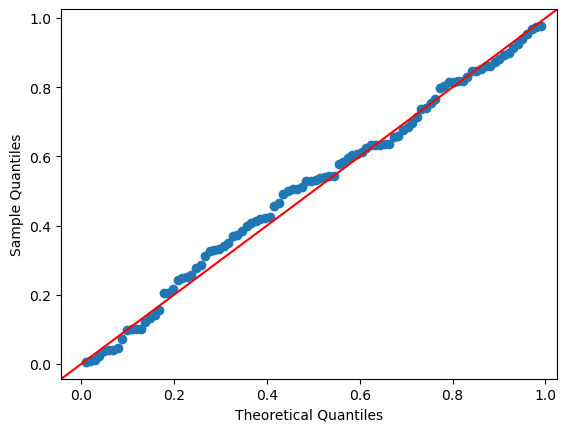

In [152]:
sm.qqplot(p_val[2,:], stats.uniform, line = '45')
pylab.show()

In [14]:
import scipy.stats as stats

In [27]:
import sys

In [29]:
!conda install --yes --prefix {sys.prefix} statsmodels

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1



# All requested packages already installed.



In [30]:
import statsmodels.api as sm
import pylab

In [92]:
def hommel_p(comb_p):
    U = len(comb_p)
    ratio = 1/np.arange(1, (U+1))
    p_order = np.min(np.sort(comb_p) * ratio * U)
    return np.min(np.append(np.sum(ratio) * p_order, 1))

def q_order_p(comb_p):
    U = len(comb_p)
    ratio = 1/np.arange(1, (U+1))
    return np.min(np.append(np.sort(comb_p) * ratio * U, 1))

In [104]:
tmp = np.apply_along_axis(q_order_p, 2, p_val)

In [105]:
tmp.shape

(6, 100)

In [198]:
!python main.py

model =  Vcnet_tr
/Users/yanyuchen/Documents/GitHub/causal_net_test/models/dynamic_net.py:83: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1680607622815/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  x_feature_weight = torch.matmul(self.weight.T, x_feature.T).T # bs, outd, d
current epoch:  0
loss:  tensor(2.1090)
current epoch:  100
loss:  tensor(1.7263)
current epoch:  200
loss:  tensor(1.6985)
current epoch:  300
loss:  tensor(1.6891)
current epoch:  400
loss:  tensor(1.6833)
current epoch:  500
loss:  tensor(1.6794)
current epoch:  600
loss:  tensor(1.6759)
current epoch:  700
loss:  tensor(1.6728)
current epoch:  800
loss:  tensor(1.6700)
current epoch:  900
loss

In [200]:
!python main_batch.py

model :  Vcnet_tr
/Users/yanyuchen/Documents/GitHub/causal_net_test/models/dynamic_net.py:83: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1680607622815/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  x_feature_weight = torch.matmul(self.weight.T, x_feature.T).T # bs, outd, d
current epoch:  0
loss:  tensor(2.0556)
current epoch:  100
loss:  tensor(1.6872)
current epoch:  200
loss:  tensor(1.6701)
current epoch:  300
loss:  tensor(1.6631)
current epoch:  400
loss:  tensor(1.6584)
current epoch:  500
loss:  tensor(1.6549)
current epoch:  600
loss:  tensor(1.6516)
current epoch:  700
loss:  tensor(1.6486)
current epoch:  800
loss:  tensor(1.6459)
current epoch:  900
loss

current epoch:  600
loss:  tensor(1.6469)
current epoch:  700
loss:  tensor(1.6437)
current epoch:  800
loss:  tensor(1.6408)
current epoch:  900
loss:  tensor(1.6381)
current loss:  1.635716199874878
current test loss:  0.0008929379982873797
-----------------------------------------------------------------
=> Saving checkpoint to logs/simu2/eval/10/Vcnet_tr_ckpt.pth.tar
-----------------------------------------------------------------
p_value:  0.06136935633006041
model :  Vcnet_tr
current epoch:  0
loss:  tensor(2.0959)
current epoch:  100
loss:  tensor(1.6793)
current epoch:  200
loss:  tensor(1.6484)
current epoch:  300
loss:  tensor(1.6397)
current epoch:  400
loss:  tensor(1.6349)
current epoch:  500
loss:  tensor(1.6309)
current epoch:  600
loss:  tensor(1.6276)
current epoch:  700
loss:  tensor(1.6244)
current epoch:  800
loss:  tensor(1.6214)
current epoch:  900
loss:  tensor(1.6184)
current loss:  1.6157444715499878
current test loss:  0.002102768048644066
-------------------

In [204]:
args.save_dir

'logs/simu2/eval'

In [208]:
delta = 0
inf_ratio = 0.3
rho = 0.4

p_val = pd.read_csv(args.save_dir + f'/p_val_delta_{delta}_at_inf_ratio_{inf_ratio}_rho_{rho}.txt', header = None)
p_val = p_val.to_numpy()

In [210]:
alpha = 0.05
(p_val < alpha).mean()

0.1

In [220]:
delta_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
rej_rate = np.zeros(len(delta_list))

In [225]:
rej_rate.reshape(1,6).shape

(1, 6)

In [228]:
np.array([delta_list, rej_rate]).shape

(2, 6)

In [ ]:
import multiprocessing as mp

delta = [x/10 for x in range(1, 6, 1)]
pool = mp.Pool()
experi = pool.map(run_simulation, delta)
pool.close()

In [19]:
int(1/0.3)

3

In [17]:
for i in delta:
    p_val = run_simulation(i)

current epoch:  0
loss:  tensor(2.0589)
current epoch:  100
loss:  tensor(1.6706)
current epoch:  200
loss:  tensor(1.6566)
current epoch:  300
loss:  tensor(1.6513)
current epoch:  400
loss:  tensor(1.6475)
current epoch:  500
loss:  tensor(1.6446)
current epoch:  600
loss:  tensor(1.6421)
current epoch:  700
loss:  tensor(1.6397)
current epoch:  800
loss:  tensor(1.6377)
current epoch:  900
loss:  tensor(1.6356)
current loss:  1.6338249444961548
current test loss:  0.004668476991355419
-----------------------------------------------------------------
=> Saving checkpoint to logs/simu2/eval/0/_delta_0.1_ckpt.pth.tar
-----------------------------------------------------------------
p_value:  0.7620814321477809
current epoch:  0
loss:  tensor(2.0662)
current epoch:  100
loss:  tensor(1.6707)
current epoch:  200
loss:  tensor(1.6595)
current epoch:  300
loss:  tensor(1.6526)
current epoch:  400
loss:  tensor(1.6475)
current epoch:  500
loss:  tensor(1.6440)
current epoch:  600
loss:  ten

current epoch:  700
loss:  tensor(1.6274)
current epoch:  800
loss:  tensor(1.6239)
current epoch:  900
loss:  tensor(1.6204)
current loss:  1.6172672510147095
current test loss:  0.017443008720874786
-----------------------------------------------------------------
=> Saving checkpoint to logs/simu2/eval/2/_delta_0.4_ckpt.pth.tar
-----------------------------------------------------------------
p_value:  0.92909642523429
current epoch:  0
loss:  tensor(2.1582)
current epoch:  100
loss:  tensor(1.7009)
current epoch:  200
loss:  tensor(1.6807)
current epoch:  300
loss:  tensor(1.6716)
current epoch:  400
loss:  tensor(1.6651)
current epoch:  500
loss:  tensor(1.6598)
current epoch:  600
loss:  tensor(1.6549)
current epoch:  700
loss:  tensor(1.6499)
current epoch:  800
loss:  tensor(1.6453)
current epoch:  900
loss:  tensor(1.6414)
current loss:  1.637581706047058
current test loss:  0.01188186276704073
-----------------------------------------------------------------
=> Saving checkpo

In [ ]:
def run_simulation(delta):
    class args_:
        data_dir = 'dataset/simu2/eval/'
        save_dir = 'logs/simu2/eval'
        num_dataset = 3
        n_epochs = 1000
        verbose = 100
    
    args = args_
    
    # splitting ratio, inf_ratio; noise size, rho
    inf_ratio = 0.3
    rho = 0.4

    # data
    load_path = args.data_dir
    num_dataset = args.num_dataset

    # save
    save_path = args.save_dir
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # fixed parameter for optimizer
    lr_type = 'fixed'
    wd = 5e-3
    momentum = 0.9

    # targeted regularization optimizer
    tr_wd = 5e-3

    num_epoch = args.n_epochs

    # check val loss
    verbose = args.verbose

    cfg_density = [(4, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    num_grid = 10
    cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
    degree = 2
    knots = [0.33, 0.66]
    model = Vcnet(cfg_density, num_grid, cfg, degree, knots)
    model._initialize_weights()

    tr_knots = list(np.arange(0.1, 1, 0.1))
    tr_degree = 2
    TargetReg = TR(tr_degree, tr_knots)
    TargetReg._initialize_weights()

    init_lr = 0.0001
    alpha = 0.5

    init_lr = 0.0001
    alpha = 0.5
    tr_init_lr = 0.001
    beta = 1.

    p_val = np.zeros(num_dataset)
    for _ in range(num_dataset):
        cur_save_path = save_path + '/' + str(_)
        if not os.path.exists(cur_save_path):
            os.makedirs(cur_save_path)

        data = pd.read_csv(load_path + '/' + str(_) + f'/delta_{delta}_data.txt', header=None, sep=' ')
        data = data.to_numpy()
        t_grid_dat = pd.read_csv(load_path + '/' + str(_) + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
        t_grid_dat = t_grid_dat.to_numpy()
        train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

        # train_matrix, test_matrix, t_grid = simu_data1(500, 200)
        train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
        test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

        # reinitialize model
        model._initialize_weights()

        # define optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=wd, nesterov=True)


        TargetReg._initialize_weights()
        tr_optimizer = torch.optim.SGD(TargetReg.parameters(), lr=tr_init_lr, weight_decay=tr_wd)

        for epoch in range(num_epoch):
            for idx, (inputs, y) in enumerate(train_loader):
                t = inputs[:, 0]
                x = inputs[:, 1:]

                optimizer.zero_grad()
                out = model.forward(t, x)
                trg = TargetReg(t)
                loss = criterion(out, y, alpha=alpha) + criterion_TR(out, trg, y, beta=beta)
                loss.backward()
                optimizer.step()

                tr_optimizer.zero_grad()
                out = model.forward(t, x)
                trg = TargetReg(t)
                tr_loss = criterion_TR(out, trg, y, beta=beta)
                tr_loss.backward()
                tr_optimizer.step()

            if epoch % verbose == 0:
                print('current epoch: ', epoch)
                print('loss: ', loss.data)

        t_grid_hat, mse = curve(model, test_matrix, t_grid, targetreg=TargetReg)

        mse = float(mse)
        print('current loss: ', float(loss.data))
        print('current test loss: ', mse)
        print('-----------------------------------------------------------------')
        save_checkpoint({
            'best_test_loss': mse,
            'model_state_dict': model.state_dict(),
            'TR_state_dict': TargetReg.state_dict(),
        }, delta=delta, checkpoint_dir=cur_save_path)
        print('-----------------------------------------------------------------')
        p_val0 = test_given_ratio(model, test_matrix, t_grid_hat, rho, TargetReg)
        print('p_value: ', p_val0)
        p_val[_] = p_val0 
    return p_val

In [5]:
import torch
import math
import numpy as np
import pandas as pd

import os
import json

from models.dynamic_net import Vcnet, TR
from data.data import get_iter, split
from utils.eval import *

def save_checkpoint(state, delta, model_name='', checkpoint_dir='.'):
    filename = os.path.join(checkpoint_dir, model_name + f'_delta_{delta}' + '_ckpt.pth.tar')
    print('=> Saving checkpoint to {}'.format(filename))
    torch.save(state, filename)

if __name__ == "__main__":

    # delta
    delta = 0.1

    


    #data_file = os.path.join(save_path, f'p_val_delta_{delta}_at_inf_ratio_{inf_ratio}_rho_{rho}.txt')
    #np.savetxt(data_file, p_val)


current epoch:  0
loss:  tensor(2.0617)
current epoch:  100
loss:  tensor(1.6812)
current epoch:  200
loss:  tensor(1.6665)
current epoch:  300
loss:  tensor(1.6612)
current epoch:  400
loss:  tensor(1.6572)
current epoch:  500
loss:  tensor(1.6535)
current epoch:  600
loss:  tensor(1.6503)
current epoch:  700
loss:  tensor(1.6475)
current epoch:  800
loss:  tensor(1.6447)
current epoch:  900
loss:  tensor(1.6422)
current loss:  1.639587640762329
current test loss:  0.0020948858000338078
-----------------------------------------------------------------
=> Saving checkpoint to logs/simu2/eval/0/_delta_0.1_ckpt.pth.tar
-----------------------------------------------------------------
p_value:  0.9953381308605203
current epoch:  0
loss:  tensor(2.1203)
current epoch:  100
loss:  tensor(1.6542)
current epoch:  200
loss:  tensor(1.6387)
current epoch:  300
loss:  tensor(1.6316)
current epoch:  400
loss:  tensor(1.6262)
current epoch:  500
loss:  tensor(1.6221)
current epoch:  600
loss:  ten

In [35]:
def kfold0(a, n):
    k, m = divmod(len(a), n)
    return [a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n)]

def kfold(dat, t_grid, inf_ratio):
    n_sample = len(t_grid[0])
    k = int(1/inf_ratio)

    perm = np.random.permutation(n_sample).tolist()
    out = kfold0(perm, k)

    new_dat = []
    for i in range(k):
        train_idx = []
        test_idx = out[i]
        for j in range(k):
            if i != j:
                train_idx += out[j]
        training = dat[train_idx, :]
        testing = dat[test_idx, :]
        t_grid_test = t_grid[:, test_idx]
        new_dat.append((torch.from_numpy(training).float(), torch.from_numpy(testing).float(), torch.from_numpy(t_grid_test).float()))
    return new_dat

In [21]:
delta = 0
data = pd.read_csv(load_path + '/' + str(_) + f'/delta_{delta}_data.txt', header=None, sep=' ')
data = data.to_numpy()
t_grid_dat = pd.read_csv(load_path + '/' + str(_) + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
t_grid_dat = t_grid_dat.to_numpy()

In [30]:
inf_ratio = 0.3
n_sample = len(t_grid_dat[0])
k = int(1/inf_ratio)

perm = np.random.permutation(n_sample).tolist()
out = kfold0(perm, k)

In [36]:
tmp = kfold(data, t_grid_dat, 0.3)

In [39]:
a, b, c = tmp[0]

In [41]:
a.shape

torch.Size([666, 6])

In [42]:
b.shape

torch.Size([334, 6])

In [47]:
!python main_batch.py

Start the case for delta = 0
dataset: 0/1
ford: 0/3
current epoch:  0
loss:  tensor(2.0862)
current epoch:  100
loss:  tensor(1.6922)
current epoch:  200
loss:  tensor(1.6613)
current epoch:  300
loss:  tensor(1.6518)
current epoch:  400
loss:  tensor(1.6458)
current epoch:  500
loss:  tensor(1.6412)
current epoch:  600
loss:  tensor(1.6372)
current epoch:  700
loss:  tensor(1.6337)
current epoch:  800
loss:  tensor(1.6305)
current epoch:  900
loss:  tensor(1.6277)
current loss:  1.625172734260559
current test loss:  0.004097567871212959
-----------------------------------------------------------------
=> Saving checkpoint to logs/simu2/eval/0/_delta_0_ckpt.pth.tar
-----------------------------------------------------------------
ford: 1/3
current epoch:  0
loss:  tensor(2.0830)
current epoch:  100
loss:  tensor(1.6724)
current epoch:  200
loss:  tensor(1.6597)
current epoch:  300
loss:  tensor(1.6537)
current epoch:  400
loss:  tensor(1.6496)
current epoch:  500
loss:  tensor(1.6456)


In [48]:
[1, 2, 3] + [4, 5, 6]

[1, 2, 3, 4, 5, 6]

In [49]:
!python simu2_generate_data.py

delta:  0
generating tuning set:  0
delta:  0
generating tuning set:  1
delta:  0
generating tuning set:  2
delta:  0
generating tuning set:  3
delta:  0
generating tuning set:  4
delta:  0
generating tuning set:  5
delta:  0
generating tuning set:  6
delta:  0
generating tuning set:  7
delta:  0
generating tuning set:  8
delta:  0
generating tuning set:  9
delta:  0
generating tuning set:  10
delta:  0
generating tuning set:  11
delta:  0
generating tuning set:  12
delta:  0
generating tuning set:  13
delta:  0
generating tuning set:  14
delta:  0
generating tuning set:  15
delta:  0
generating tuning set:  16
delta:  0
generating tuning set:  17
delta:  0
generating tuning set:  18
delta:  0
generating tuning set:  19
delta:  0
generating tuning set:  20
delta:  0
generating tuning set:  21
delta:  0
generating tuning set:  22
delta:  0
generating tuning set:  23
delta:  0
generating tuning set:  24
delta:  0
generating tuning set:  25
delta:  0
generating tuning set:  26
delta:  0
g

delta:  0.2
generating tuning set:  16
delta:  0.2
generating tuning set:  17
delta:  0.2
generating tuning set:  18
delta:  0.2
generating tuning set:  19
delta:  0.2
generating tuning set:  20
delta:  0.2
generating tuning set:  21
delta:  0.2
generating tuning set:  22
delta:  0.2
generating tuning set:  23
delta:  0.2
generating tuning set:  24
delta:  0.2
generating tuning set:  25
delta:  0.2
generating tuning set:  26
delta:  0.2
generating tuning set:  27
delta:  0.2
generating tuning set:  28
delta:  0.2
generating tuning set:  29
delta:  0.2
generating tuning set:  30
delta:  0.2
generating tuning set:  31
delta:  0.2
generating tuning set:  32
delta:  0.2
generating tuning set:  33
delta:  0.2
generating tuning set:  34
delta:  0.2
generating tuning set:  35
delta:  0.2
generating tuning set:  36
delta:  0.2
generating tuning set:  37
delta:  0.2
generating tuning set:  38
delta:  0.2
generating tuning set:  39
delta:  0.2
generating tuning set:  40
delta:  0.2
generating tu

delta:  0.4
generating tuning set:  27
delta:  0.4
generating tuning set:  28
delta:  0.4
generating tuning set:  29
delta:  0.4
generating tuning set:  30
delta:  0.4
generating tuning set:  31
delta:  0.4
generating tuning set:  32
delta:  0.4
generating tuning set:  33
delta:  0.4
generating tuning set:  34
delta:  0.4
generating tuning set:  35
delta:  0.4
generating tuning set:  36
delta:  0.4
generating tuning set:  37
delta:  0.4
generating tuning set:  38
delta:  0.4
generating tuning set:  39
delta:  0.4
generating tuning set:  40
delta:  0.4
generating tuning set:  41
delta:  0.4
generating tuning set:  42
delta:  0.4
generating tuning set:  43
delta:  0.4
generating tuning set:  44
delta:  0.4
generating tuning set:  45
delta:  0.4
generating tuning set:  46
delta:  0.4
generating tuning set:  47
delta:  0.4
generating tuning set:  48
delta:  0.4
generating tuning set:  49
delta:  0.4
generating tuning set:  50
delta:  0.4
generating tuning set:  51
delta:  0.4
generating tu

In [56]:
!python turning.py

Start the case for delta = 0; inf_ratio = 0.15
permutation: 0/1
End the case for delta = 0; inf_ratio = 0.15
Delta statistics saved to logs/simu2/tune
-----------------------------------------------------------------
-----------------------------------------------------------------
Start the case for delta = 0.5; inf_ratio = 0.15
permutation: 0/1
End the case for delta = 0.5; inf_ratio = 0.15
Delta statistics saved to logs/simu2/tune
-----------------------------------------------------------------
-----------------------------------------------------------------
Program done. Complete all Delta statistics


In [12]:
from scipy.stats import norm, uniform
import statsmodels.api as sm
import pylab
import numpy as np
import pandas as pd

import argparse

def turn_rho(delta0, rho, alpha = 0.05):
    U, n_test = delta0.shape
    p_val = np.zeros(len(rho) * U).reshape(len(rho), U)
    rej = np.zeros(len(rho))
    for _ in range(len(rho)):
        noise = rho[_]
        delta = delta0 + noise * np.random.normal(size = U * n_test).reshape(U, n_test)
        theta = delta.sum(axis = 1) / (np.sqrt(n_test) * delta.std(axis = 1))
        p_val[_,:] = norm.cdf(theta)
        rej[_] = (p_val[_,:] <= alpha).mean()
    return p_val, rej

In [31]:
class args_:
    save_dir = 'logs/simu2/tune'
    U = 100
args = args_

In [69]:
delta = 0
inf_ratio = 0.08
Delta = pd.read_csv(args.save_dir + f'/Delta_delta_{delta}_inf_ratio_{inf_ratio}_U_{args.U}.txt', header=None, sep=' ')

In [70]:
rho = [0.03, 0.05, 0.08, 0.1, 0.15]
rej = np.zeros(len(rho))
num = 1000
for i in range(num):
    p_val, rej0 = turn_rho(Delta , rho)
    rej += rej0
rej /= num
rej

array([0.09274, 0.0735 , 0.06392, 0.0611 , 0.05919])

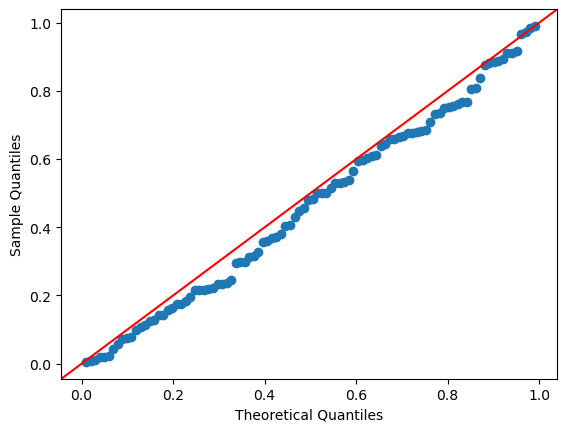

In [71]:
sm.qqplot(p_val[1,:], uniform, line = '45')
pylab.show()

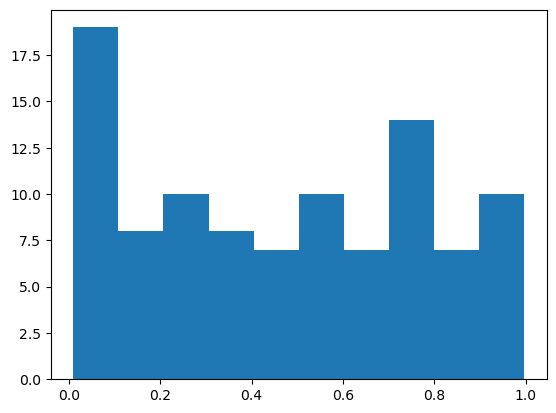

In [63]:
import matplotlib.pyplot as plt
plt.hist(p_val[2,:])
plt.show()

In [68]:
!python main_batch.py

Start the case for delta = 0
dataset: 1/1
ford: 1/2
current loss:  1.627439260482788
current test loss:  0.0008023419068194926
ford: 2/2
current loss:  1.6250126361846924
current test loss:  0.0015025875763967633
End the case for delta = 0
p-values saved to logs/simu2/eval
run time saved to logs/simu2/eval
-----------------------------------------------------------------
-----------------------------------------------------------------
Complete all p-values; now calculate the rejection rate...
rejection rate done, saved to logs/simu2/eval
Program done


In [12]:
num = int(1e+6)
X1 = np.random.uniform(size = num)
X2 = np.random.uniform(size = num)
np.maximum(X1, X2).mean()

0.6663966947472666

In [ ]:
class args_:
    data_dir = 'dataset/simu2/eval/0'
    save_dir = 'logs/simu2/eval'
    n_epochs = 1000
    verbose = 100
    plt_adrf = True
    
args = args_

In [64]:
!python simu1_generate_data.py

delta:  0
generating tuning set:  0
delta:  0
generating eval set:  0
delta:  0
generating eval set:  1
delta:  0
generating eval set:  2
delta:  0
generating eval set:  3
delta:  0
generating eval set:  4
delta:  0
generating eval set:  5
delta:  0
generating eval set:  6
delta:  0
generating eval set:  7
delta:  0
generating eval set:  8
delta:  0
generating eval set:  9
delta:  0
generating eval set:  10
delta:  0
generating eval set:  11
delta:  0
generating eval set:  12
delta:  0
generating eval set:  13
delta:  0
generating eval set:  14
delta:  0
generating eval set:  15
delta:  0
generating eval set:  16
delta:  0
generating eval set:  17
delta:  0
generating eval set:  18
delta:  0
generating eval set:  19
delta:  0
generating eval set:  20
delta:  0
generating eval set:  21
delta:  0
generating eval set:  22
delta:  0
generating eval set:  23
delta:  0
generating eval set:  24
delta:  0
generating eval set:  25
delta:  0
generating eval set:  26
delta:  0
generating eval set

In [65]:
import time

import numpy as np
import pandas as pd
import torch

from data.simu1 import *
from data.data import *
from utils.eval import *

In [66]:
num_dataset = 1
load_path = 'dataset/simu1/eval/'

delta_list = [1] #[x/10 for x in range(0, 6, 1)] #[0, 0.5]

# splitting ratio, inf_ratio; noise size, rho
inf_ratio = 0.1 #0.15 #0.3
rho = 0.135 #0.15 #0.4

for delta in delta_list:
    print(f'Start the case for delta = {delta}')

    p_val = np.zeros(num_dataset)
    run_time = np.zeros(num_dataset)
    for _ in range(num_dataset):
        print(f'dataset: {_ + 1}/{num_dataset}')

        data = pd.read_csv(load_path + '/' + str(_) + f'/delta_{delta}_data.txt', header=None, sep=' ')
        data = data.to_numpy()
        t_grid_dat = pd.read_csv(load_path + '/' + str(_) + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
        t_grid_dat = t_grid_dat.to_numpy()

        each_fold = kfold(data, t_grid_dat, inf_ratio)
        k = len(each_fold)
        Delta_all = []

        # get the start time
        st = time.time()
        for i in range(k):
            print(f'ford: {i + 1}/{k}')
            train_matrix, test_matrix, t_grid = each_fold[i]
            
            n_test = test_matrix.shape[0]
            t_grid_hat = t_grid
            g_hat = t_grid_hat[1]
            g_tilde = torch.mean(g_hat).repeat(n_test)

            mu_tr = torch.zeros(n_test, n_test)
            for i in range(n_test):
                t = test_matrix[:,0]
                x = test_matrix[i,1:5]
                mu_tr[:,i] = t_x_y(t, x, delta)

            Delta = torch.mean((mu_tr - torch.reshape(g_hat, (n_test,1)).repeat(1, n_test)) ** 2, 1) - torch.mean((mu_tr - torch.reshape(g_tilde, (n_test,1)).repeat(1, n_test)) ** 2, 1)
            Delta = Delta.numpy()
            Delta_all += Delta.tolist()

        p_val0 = test_from_delta(np.array(Delta_all), rho)
        p_val0 = 0
        # get the end time
        et = time.time()
        # get the execution time
        elapsed_time = et - st

        run_time[_] = elapsed_time
        #print('p_value: ', p_val0)
        p_val[_] = p_val0

    print(f'End the case for delta = {delta}')
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')

Start the case for delta = 1
dataset: 1/1
ford: 1/10


IndexError: index 5 is out of bounds for dimension 0 with size 4

In [70]:
test_matrix[i,:]

tensor([ 0.0419,  0.3752,  0.0760,  0.3732,  0.3614,  0.6315,  0.8936, -0.9394])

In [71]:
x = test_matrix[i,1:7]
x

tensor([0.3752, 0.0760, 0.3732, 0.3614, 0.6315, 0.8936])

In [91]:
import torch
import math
import numpy as np
import os
import pandas as pd

from models.dynamic_net import Vcnet, TR #Drnet
from data.data import get_iter, split
from utils.eval import *

import matplotlib.pyplot as plt

In [83]:
class args_:
    data_dir = 'dataset/simu2/eval/0'
    #save_dir = 'logs/simu1/eval'
    n_epochs = 800
    verbose = 100
    plt_adrf = True
    
args = args_

current epoch:  0
loss:  tensor(4.0526)
current epoch:  100
loss:  tensor(1.6921)
current epoch:  200
loss:  tensor(1.6811)
current epoch:  300
loss:  tensor(1.6747)
current epoch:  400
loss:  tensor(1.6702)
current epoch:  500
loss:  tensor(1.6664)
current epoch:  600
loss:  tensor(1.6629)
current epoch:  700
loss:  tensor(1.6599)


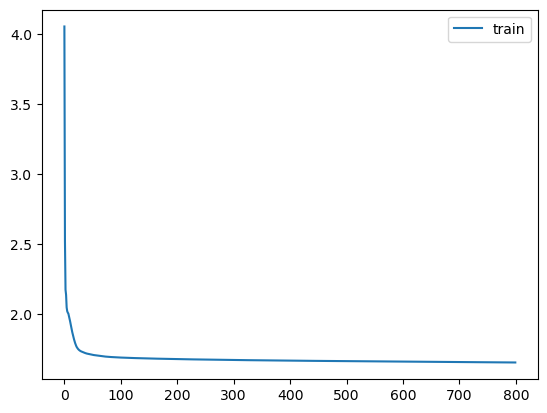

In [93]:
if __name__ == "__main__":
    # delta
    delta = 0.5

    # splitting ratio, inf_ratio; noise size, rho
    inf_ratio = 0.2
    #rho = 0.4

    # dir
    load_path = args.data_dir
    #save_path = args.save_dir
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = pd.read_csv(load_path + f'/delta_{delta}_data.txt', header=None, sep=' ')
    data = data.to_numpy()
    t_grid_dat = pd.read_csv(load_path + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
    t_grid_dat = t_grid_dat.to_numpy()
    train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

    train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
    test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

    # optimizer
    lr_type = 'fixed'
    wd = 5e-3
    momentum = 0.9
    # targeted regularization optimizer
    tr_wd = 5e-3

    num_epoch = args.n_epochs

    # check val loss
    verbose = args.verbose
    
    cfg_density = [(4, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    #cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    num_grid = 10
    cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
    degree = 2
    knots = [0.33, 0.66]
    model = Vcnet(cfg_density, num_grid, cfg, degree, knots)
    model._initialize_weights()

    tr_knots = list(np.arange(0.1, 1, 0.1))
    tr_degree = 2
    TargetReg = TR(tr_degree, tr_knots)
    TargetReg._initialize_weights()

    init_lr = 0.0001 #0.00005 #0.0005
    alpha = 0.5
    tr_init_lr = 0.001
    beta = 1.

    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=wd, nesterov=True)

    tr_optimizer = torch.optim.SGD(TargetReg.parameters(), lr=tr_init_lr, weight_decay=tr_wd)

    loss_values = []
    for epoch in range(num_epoch):
        for idx, (inputs, y) in enumerate(train_loader):
            t = inputs[:, 0]
            x = inputs[:, 1:]

            optimizer.zero_grad()
            out = model.forward(t, x)
            trg = TargetReg(t)
            loss = criterion(out, y, alpha=alpha) + criterion_TR(out, trg, y, beta=beta)
            loss.backward()
            optimizer.step()

            tr_optimizer.zero_grad()
            out = model.forward(t, x)
            trg = TargetReg(t)
            tr_loss = criterion_TR(out, trg, y, beta=beta)
            tr_loss.backward()
            tr_optimizer.step()

            loss_values.append(loss.data)

        if epoch % verbose == 0:
            print('current epoch: ', epoch)
            print('loss: ', loss.data)

    t_grid_hat, mse = curve(model, test_matrix, t_grid, targetreg=TargetReg)

    #grid.append(t_grid_hat)

    plt.plot(loss_values, label = 'train')
    plt.legend(loc='upper right')
    plt.show()
    #plt.savefig(save_path + "/train_loss.pdf", bbox_inches='tight')

In [59]:
DRDR = pd.read_csv('R/logs/simu2/eval/fit_delta_0.5.txt', header=None, sep=' ')
DRDR = DRDR.to_numpy()

In [69]:
T_grid = torch.arange(1, test_matrix.shape[0] + 1)/test_matrix.shape[0]
test_matrix[:,0] = T_grid

n_test = test_matrix.shape[0]
t_grid_hat = torch.zeros(2, n_test)
t_grid_hat[0, :] = T_grid

test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

In [79]:
for _ in range(n_test):
    for idx, (inputs, y) in enumerate(test_loader):
        t = inputs[:, 0]
        t *= 0
        t += t_grid[0, _]
        x = inputs[:, 1:]
        break
    out = model.forward(t, x)
    tr_out = TargetReg(t).data
    g = out[0].data.squeeze()
    out = out[1].data.squeeze() + tr_out / (g + pi_low)
    out = out.mean()
    t_grid_hat[1, _] = out

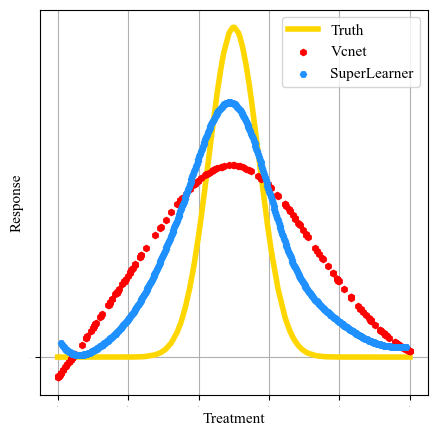

In [94]:
if args.plt_adrf:
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }

    font_legend = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }
    plt.figure(figsize=(5, 5))

    c1 = 'gold'
    c2 = 'red'
    c3 = 'dodgerblue'

    truth_grid = t_grid[:,t_grid[0,:].argsort()]
    x = truth_grid[0, :]
    y = truth_grid[1, :]
    plt.plot(x, y, marker='', ls='-', label='Truth', linewidth=4, color=c1)

    grid = [t_grid_hat]
    x = grid[0][0, :]
    y = grid[0][1, :]
    plt.scatter(x, y, marker='h', label='Vcnet', alpha=1, zorder=2, color=c2, s=20)

    #x = grid[0][0, :]
    #y = grid[0][1, :]
    #plt.scatter(x, y.mean().repeat(y.shape), marker='H', label='mean(Vcnet)', alpha=1, zorder=3, color=c3, s=20)
    
    x = DRDR[:,0]
    y = DRDR[:,1]
    plt.scatter(x, y, marker='H', label='SuperLearner', alpha=1, zorder=3, color=c3, s=20)

    plt.yticks(np.arange(1, 1.5, 0.5), fontsize=0, family='Times New Roman')
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=0, family='Times New Roman')
    plt.grid()
    plt.legend(prop=font_legend, loc='upper right')
    plt.xlabel('Treatment', font1)
    plt.ylabel('Response', font1)
    
    #plt.vlines(x = 0.01, ymin = min(y), ymax = max(y))
    #plt.vlines(x = 0.01, ymin = -2, ymax = 1.1)
    #plt.vlines(x = 0.99, ymin = -2, ymax = 1.1)
    #plt.savefig(save_path + "/Vc_Dr.pdf", bbox_inches='tight')
    plt.show()

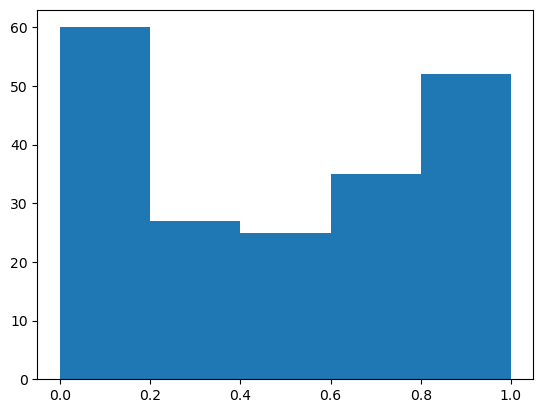

In [97]:
plt.hist(t_grid_hat[0,:], bins = 5)
plt.show()

In [205]:
class args_:
    data_dir = 'dataset/simu1/eval/0'
    #save_dir = 'logs/simu1/eval'
    n_epochs = 2200
    verbose = 100
    plt_adrf = True
    
args = args_

current epoch:  0
loss:  tensor(4.2275)
current epoch:  100
loss:  tensor(1.8321)
current epoch:  200
loss:  tensor(1.8207)
current epoch:  300
loss:  tensor(1.8140)
current epoch:  400
loss:  tensor(1.8083)
current epoch:  500
loss:  tensor(1.8025)
current epoch:  600
loss:  tensor(1.7965)
current epoch:  700
loss:  tensor(1.7908)
current epoch:  800
loss:  tensor(1.7852)
current epoch:  900
loss:  tensor(1.7800)
current epoch:  1000
loss:  tensor(1.7755)
current epoch:  1100
loss:  tensor(1.7715)
current epoch:  1200
loss:  tensor(1.7679)
current epoch:  1300
loss:  tensor(1.7644)
current epoch:  1400
loss:  tensor(1.7613)
current epoch:  1500
loss:  tensor(1.7585)
current epoch:  1600
loss:  tensor(1.7556)
current epoch:  1700
loss:  tensor(1.7523)
current epoch:  1800
loss:  tensor(1.7496)
current epoch:  1900
loss:  tensor(1.7472)
current epoch:  2000
loss:  tensor(1.7448)
current epoch:  2100
loss:  tensor(1.7423)
current loss:  1.73995041847229
current test loss:  0.008485499769

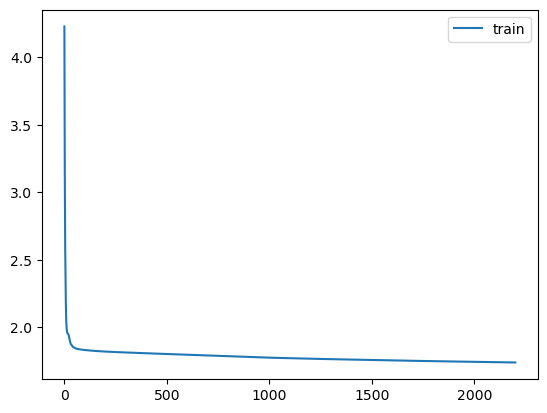

In [206]:
if __name__ == "__main__":
    # delta
    delta = 0.5

    # splitting ratio, inf_ratio; noise size, rho
    inf_ratio = 0.2
    #rho = 0.4

    # dir
    load_path = args.data_dir
    #save_path = args.save_dir
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = pd.read_csv(load_path + f'/delta_{delta}_data.txt', header=None, sep=' ')
    data = data.to_numpy()
    t_grid_dat = pd.read_csv(load_path + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
    t_grid_dat = t_grid_dat.to_numpy()
    train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

    train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
    test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

    # optimizer
    lr_type = 'fixed'
    wd = 5e-3
    momentum = 0.9
    # targeted regularization optimizer
    tr_wd = 5e-3

    num_epoch = args.n_epochs

    # check val loss
    verbose = args.verbose
    
    #cfg_density = [(4, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    num_grid = 10
    cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
    degree = 2
    knots = [0.33, 0.66]
    model = Vcnet(cfg_density, num_grid, cfg, degree, knots)
    model._initialize_weights()

    tr_knots = list(np.arange(0.1, 1, 0.1))
    tr_degree = 2
    TargetReg = TR(tr_degree, tr_knots)
    TargetReg._initialize_weights()

    init_lr = 0.0001 #0.00005 #0.0005
    alpha = 0.5
    tr_init_lr = 0.001
    beta = 1.

    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=wd, nesterov=True)

    tr_optimizer = torch.optim.SGD(TargetReg.parameters(), lr=tr_init_lr, weight_decay=tr_wd)

    loss_values = []
    for epoch in range(num_epoch):
        for idx, (inputs, y) in enumerate(train_loader):
            t = inputs[:, 0]
            x = inputs[:, 1:]

            optimizer.zero_grad()
            out = model.forward(t, x)
            trg = TargetReg(t)
            loss = criterion(out, y, alpha=alpha) + criterion_TR(out, trg, y, beta=beta)
            loss.backward()
            optimizer.step()

            tr_optimizer.zero_grad()
            out = model.forward(t, x)
            trg = TargetReg(t)
            tr_loss = criterion_TR(out, trg, y, beta=beta)
            tr_loss.backward()
            tr_optimizer.step()

            loss_values.append(loss.data)

        if epoch % verbose == 0:
            print('current epoch: ', epoch)
            print('loss: ', loss.data)

    t_grid_hat, mse = curve(model, test_matrix, t_grid, targetreg=TargetReg)

    mse = float(mse)
    print('current loss: ', float(loss.data))
    print('current test loss: ', mse)
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')

    #grid.append(t_grid_hat)

    plt.plot(loss_values, label = 'train')
    plt.legend(loc='upper right')
    plt.show()
    #plt.savefig(save_path + "/train_loss.pdf", bbox_inches='tight')

In [207]:
DRDR0 = pd.read_csv('R/logs/simu1/eval/fit_delta_0.5.txt', header=None, sep=' ')
DRDR0 = DRDR0.to_numpy()

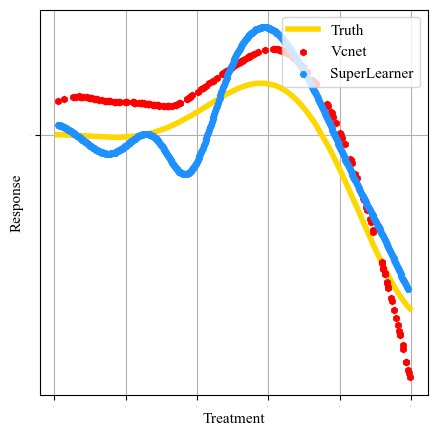

In [208]:
if args.plt_adrf:
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }

    font_legend = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }
    plt.figure(figsize=(5, 5))

    c1 = 'gold'
    c2 = 'red'
    c3 = 'dodgerblue'

    truth_grid = t_grid[:,t_grid[0,:].argsort()]
    x = truth_grid[0, :]
    y = truth_grid[1, :]
    plt.plot(x, y, marker='', ls='-', label='Truth', linewidth=4, color=c1)

    grid = [t_grid_hat]
    x = grid[0][0, :]
    y = grid[0][1, :]
    plt.scatter(x, y, marker='h', label='Vcnet', alpha=1, zorder=2, color=c2, s=20)

    #x = grid[0][0, :]
    #y = grid[0][1, :]
    #plt.scatter(x, y.mean().repeat(y.shape), marker='H', label='mean(Vcnet)', alpha=1, zorder=3, color=c3, s=20)
    
    x = DRDR0[:,0]
    y = DRDR0[:,1]
    plt.scatter(x, y, marker='H', label='SuperLearner', alpha=1, zorder=3, color=c3, s=20)

    plt.yticks(np.arange(1, 1.5, 0.5), fontsize=0, family='Times New Roman')
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=0, family='Times New Roman')
    plt.grid()
    plt.legend(prop=font_legend, loc='upper right')
    plt.xlabel('Treatment', font1)
    plt.ylabel('Response', font1)
    
    #plt.vlines(x = 0.01, ymin = min(y), ymax = max(y))
    #plt.vlines(x = 0.01, ymin = -2, ymax = 1.1)
    #plt.vlines(x = 0.99, ymin = -2, ymax = 1.1)
    #plt.savefig(save_path + "/Vc_Dr.pdf", bbox_inches='tight')
    plt.show()

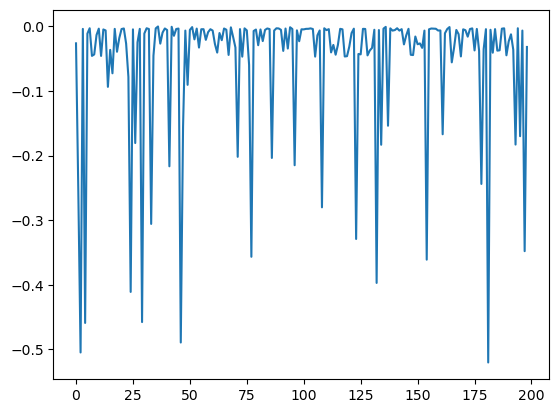

In [209]:
tmp1 = calculate_delta(model, test_matrix, t_grid_hat, TargetReg)
plt.plot(tmp1)
plt.show()

In [210]:
test_from_delta(tmp1, 0.135)

array([5.31561704e-06])

In [2]:
class args_:
    data_dir = 'dataset/simu1/eval/0'
    #save_dir = 'logs/simu1/eval'
    n_epochs = 800
    verbose = 100
    plt_adrf = True
    
args = args_

/Users/yanyuchen/Documents/GitHub/causal_net_test/models/dynamic_net.py:83: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1680607622815/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  x_feature_weight = torch.matmul(self.weight.T, x_feature.T).T # bs, outd, d


current epoch:  0
loss:  tensor(4.2439)
current epoch:  100
loss:  tensor(1.8719)
current epoch:  200
loss:  tensor(1.8660)
current epoch:  300
loss:  tensor(1.8606)
current epoch:  400
loss:  tensor(1.8560)
current epoch:  500
loss:  tensor(1.8516)
current epoch:  600
loss:  tensor(1.8473)
current epoch:  700
loss:  tensor(1.8429)
current loss:  1.838738203048706
current test loss:  0.006910244934260845
-----------------------------------------------------------------
-----------------------------------------------------------------


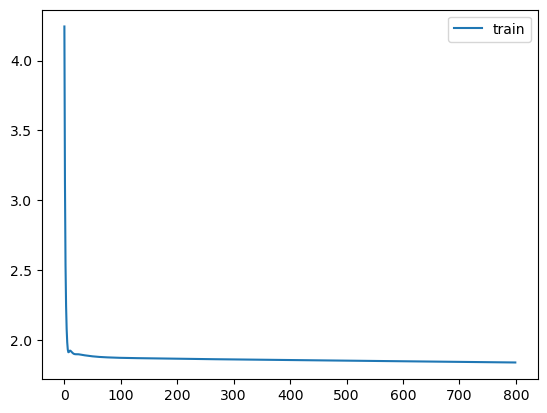

In [5]:
if __name__ == "__main__":
    # delta
    delta = 0

    # splitting ratio, inf_ratio; noise size, rho
    inf_ratio = 0.2
    #rho = 0.4

    # dir
    load_path = args.data_dir
    #save_path = args.save_dir
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = pd.read_csv(load_path + f'/delta_{delta}_data.txt', header=None, sep=' ')
    data = data.to_numpy()
    t_grid_dat = pd.read_csv(load_path + f'/delta_{delta}_t_grid.txt', header=None, sep=' ')
    t_grid_dat = t_grid_dat.to_numpy()
    train_matrix, test_matrix, t_grid = split(data, t_grid_dat, inf_ratio)

    train_loader = get_iter(train_matrix, batch_size=train_matrix.shape[0], shuffle=True)
    test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

    # optimizer
    lr_type = 'fixed'
    wd = 5e-3
    momentum = 0.9
    # targeted regularization optimizer
    tr_wd = 5e-3

    num_epoch = args.n_epochs

    # check val loss
    verbose = args.verbose
    
    #cfg_density = [(4, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    cfg_density = [(6, 50, 1, 'relu'), (50, 50, 1, 'relu')]
    num_grid = 10
    cfg = [(50, 50, 1, 'relu'), (50, 1, 1, 'id')]
    degree = 2
    knots = [0.33, 0.66]
    model = Vcnet(cfg_density, num_grid, cfg, degree, knots)
    model._initialize_weights()

    tr_knots = list(np.arange(0.1, 1, 0.1))
    tr_degree = 2
    TargetReg = TR(tr_degree, tr_knots)
    TargetReg._initialize_weights()

    init_lr = 0.0001 #0.00005 #0.0005
    alpha = 0.5
    tr_init_lr = 0.001
    beta = 1.

    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=wd, nesterov=True)

    tr_optimizer = torch.optim.SGD(TargetReg.parameters(), lr=tr_init_lr, weight_decay=tr_wd)

    loss_values = []
    for epoch in range(num_epoch):
        for idx, (inputs, y) in enumerate(train_loader):
            t = inputs[:, 0]
            x = inputs[:, 1:]

            optimizer.zero_grad()
            out = model.forward(t, x)
            trg = TargetReg(t)
            loss = criterion(out, y, alpha=alpha) + criterion_TR(out, trg, y, beta=beta)
            loss.backward()
            optimizer.step()

            tr_optimizer.zero_grad()
            out = model.forward(t, x)
            trg = TargetReg(t)
            tr_loss = criterion_TR(out, trg, y, beta=beta)
            tr_loss.backward()
            tr_optimizer.step()

            loss_values.append(loss.data)

        if epoch % verbose == 0:
            print('current epoch: ', epoch)
            print('loss: ', loss.data)

    t_grid_hat, mse = curve(model, test_matrix, t_grid, targetreg=TargetReg)

    mse = float(mse)
    print('current loss: ', float(loss.data))
    print('current test loss: ', mse)
    print('-----------------------------------------------------------------')
    print('-----------------------------------------------------------------')

    #grid.append(t_grid_hat)

    plt.plot(loss_values, label = 'train')
    plt.legend(loc='upper right')
    plt.show()
    #plt.savefig(save_path + "/train_loss.pdf", bbox_inches='tight')

In [6]:
DRDR0_ = pd.read_csv('R/logs/simu1/eval/fit_delta_0.txt', header=None, sep=' ')
DRDR0_ = DRDR0_.to_numpy()

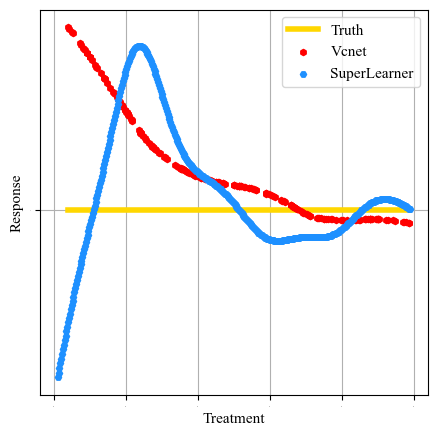

In [7]:
if args.plt_adrf:
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }

    font_legend = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }
    plt.figure(figsize=(5, 5))

    c1 = 'gold'
    c2 = 'red'
    c3 = 'dodgerblue'

    truth_grid = t_grid[:,t_grid[0,:].argsort()]
    x = truth_grid[0, :]
    y = truth_grid[1, :]
    plt.plot(x, y, marker='', ls='-', label='Truth', linewidth=4, color=c1)

    grid = [t_grid_hat]
    x = grid[0][0, :]
    y = grid[0][1, :]
    plt.scatter(x, y, marker='h', label='Vcnet', alpha=1, zorder=2, color=c2, s=20)

    #x = grid[0][0, :]
    #y = grid[0][1, :]
    #plt.scatter(x, y.mean().repeat(y.shape), marker='H', label='mean(Vcnet)', alpha=1, zorder=3, color=c3, s=20)
    
    x = DRDR0_[:,0]
    y = DRDR0_[:,1]
    plt.scatter(x, y, marker='H', label='SuperLearner', alpha=1, zorder=3, color=c3, s=20)

    plt.yticks(np.arange(1, 1.5, 0.5), fontsize=0, family='Times New Roman')
    plt.xticks(np.arange(0, 1.1, 0.2), fontsize=0, family='Times New Roman')
    plt.grid()
    plt.legend(prop=font_legend, loc='upper right')
    plt.xlabel('Treatment', font1)
    plt.ylabel('Response', font1)
    
    #plt.vlines(x = 0.01, ymin = min(y), ymax = max(y))
    #plt.vlines(x = 0.01, ymin = -2, ymax = 1.1)
    #plt.vlines(x = 0.99, ymin = -2, ymax = 1.1)
    #plt.savefig(save_path + "/Vc_Dr.pdf", bbox_inches='tight')
    plt.show()

In [187]:
from utils.eval import calculate_delta, test_from_delta

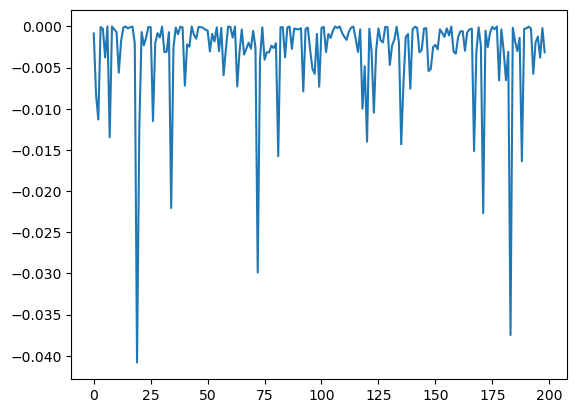

In [202]:
tmp = calculate_delta(model, test_matrix, t_grid_hat, TargetReg)
plt.plot(tmp)
plt.show()

In [203]:
test_from_delta(tmp, 0.135)

array([0.60212305])

In [162]:
from data.simu1 import t_x_y, g_t

In [153]:
import torch

In [11]:
t = data[:,0]
#t = torch.from_numpy(t)
x = data[:,1:7]
#x = torch.from_numpy(x)

In [169]:
adrc = torch.zeros(t.shape[0])
cdrc = torch.zeros(t.shape[0])
delta = 0

for _ in range(t.shape[0]):
    adrc[_] = g_t(t[_], delta)
    cdrc[_] = t_x_y(t[_],x[_,:],delta)

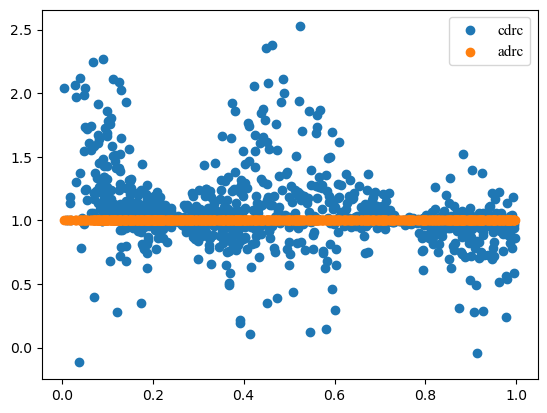

In [170]:
font_legend = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 11,
    }
plt.scatter(t, cdrc, label='cdrc')
plt.scatter(t, adrc, label='adrc')
plt.legend(prop=font_legend, loc='upper right')
plt.show()

In [30]:
arange = [0.01, 0.99]
pi_low = 1e-6

mask = np.logical_or(test_matrix[:,0] > arange[0], test_matrix[:,0] < arange[1]).bool()
test_matrix = test_matrix[mask,:]
t_grid = t_grid[:,mask]

n_test = t_grid.shape[1]

test_loader = get_iter(test_matrix, batch_size=test_matrix.shape[0], shuffle=False)

for _ in range(n_test):
    for idx, (inputs, y) in enumerate(test_loader):
        t = inputs[:, 0]
        t *= 0
        t += t_grid[0, _]
        x = inputs[:, 1:]
        break
    out = model.forward(t, x)
    tr_out = TargetReg(t).data
    g = out[0].data.squeeze()
    #out = out[1].data.squeeze() + tr_out / (g + pi_low)

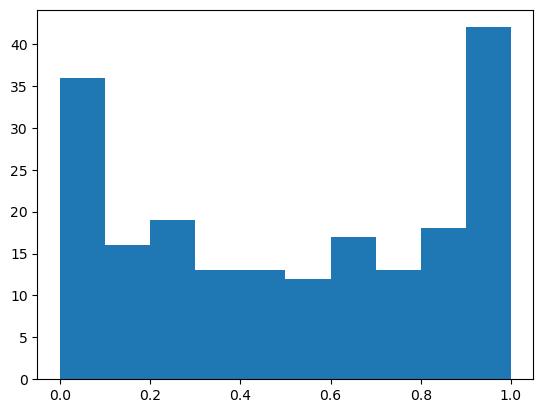

In [41]:
plt.hist(test_matrix[:,0].detach().numpy())
plt.show()

In [53]:
T_grid = torch.arange(1, test_matrix.shape[0] + 1)/test_matrix.shape[0]
T_grid.shape

torch.Size([199])

In [54]:
tmp = test_matrix
tmp[:,0] = T_grid

In [56]:
test_matrix.shape[0]

199